In [19]:
### Example of EEG-fMRI Denoising

In [ ]:
import mne
import numpy as np


def remove_gradients(
    raw,
    event_name="Gradient/G  1",
    event_offset=0.0,
    window_length=None,
    baseline_correction=False,
    baseline=None,
):
    """
    Remove gradient artefact from raw M/EEG data using
    average artefact subtraction (AAS), while keeping
    the full continuous recording.
    """

    # -----------------------------
    # Load data
    # -----------------------------`        `
    raw.load_data()
    sfreq = raw.info["sfreq"]

    # -----------------------------
    # Sliding window logic
    # -----------------------------
    sliding_window = True
    if window_length is None:
        print("No window length selected. Using all volumes for template.")
        sliding_window = False
    elif window_length % 2 == 0:
        window_length += 1
        print(f"Window length must be odd. Using {window_length} instead.")

    # -----------------------------
    # Get gradient events
    # -----------------------------
    events, events_id = mne.events_from_annotations(raw)
    if event_name not in events_id:
        raise ValueError(f"{event_name} not found in annotations.")

    grad_events = events[events[:, 2] == events_id[event_name]].copy()
    n_events = len(grad_events)

    if n_events < 2:
        raise ValueError("Need at least 2 events to estimate TR.")

    # -----------------------------
    # Apply offset ONCE (in samples)
    # -----------------------------
    offset_samp = int(round(event_offset * sfreq))
    print(f'OFFSET SAMP = {offset_samp}')
    grad_events[:, 0] += offset_samp

    # -----------------------------
    # Compute TR
    # -----------------------------
    tr_samples = grad_events[1, 0] - grad_events[0, 0]
    tr_sec = tr_samples / sfreq
    print(f"Scanner Repetition Time = {tr_sec:.3f} s")

    # -----------------------------
    # Epoching (now simple)
    # -----------------------------
    epochs = mne.Epochs(
        raw,
        grad_events,
        tmin=0,
        tmax=tr_sec- (1 / sfreq), ### TODO - (1 / sfreq) THIS IS VERY IMPORTANT, DO WE DEFO NEED IT? IS IT DOING WHAT WE THINK
        baseline=None,
        preload=True,
        reject_by_annotation=True,
    )

    data = epochs.get_data()  # (n_epochs, n_channels, n_times)
    n_epochs, n_channels, n_times = data.shape

    half_win = window_length // 2 if sliding_window else 0

    # -----------------------------
    # Main AAS loop
    # -----------------------------
    for ch in range(n_channels):

        ch_epochs = data[:, ch, :]  # (n_epochs, n_times)

        for i, event in enumerate(grad_events):

            # Template construction
            if not sliding_window:
                noise_avg = ch_epochs.mean(axis=0)
            else:
                w_start = max(0, i - half_win)
                w_stop = min(n_events, i + half_win + 1)
                noise_avg = ch_epochs[w_start:w_stop].mean(axis=0)

            # Optional baseline correction
            if baseline_correction:
                if baseline is not None:
                    b_start = int((baseline[0] / tr_sec) * n_times)
                    b_stop = int((baseline[1] / tr_sec) * n_times)
                    noise_avg -= noise_avg[b_start:b_stop].mean()
                else:
                    noise_avg -= noise_avg.mean()

            # Subtract artefact
            start = event[0]
            stop = start + n_times

            if start < 0 or stop > raw.n_times:
                continue

            raw._data[ch, start:stop] -= noise_avg

    return raw


In [52]:
raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_5488\401351902.py:1: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)
C:\Users\brand\AppData\Local\Temp\ipykernel_5488\401351902.py:1: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


In [53]:
raw.info["bads"].append("Cz")

In [54]:
raw.interpolate_bads()

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 1 sensors


<RawBrainVision | sub-01_task-da_run-03_eeg.eeg, 68 x 3696600 (739.3 s), ~1.87 GiB, data loaded>

In [56]:
clean_raw = remove_gradients(raw.copy(),  window_length=61,baseline_correction=True)

Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
OFFSET SAMP = 0
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped


In [48]:
import numpy as np
import mne
import matplotlib.pyplot as plt


def gradient_locked_rms(
    raw,
    event_name="Gradient/G  1",
    plot=True,
):
    """
    Compute gradient-locked residual RMS and RMS over time,
    and optionally plot the average gradient-locked epoch.

    Parameters
    ----------
    raw : mne.io.Raw
        Continuous EEG-fMRI recording with gradient annotations.
    event_name : str
        Annotation label corresponding to gradient triggers.
    plot : bool
        Whether to plot diagnostics.

    Returns
    -------
    rms_scalar : float
        Mean residual RMS averaged across epochs, channels, and time.
    times : np.ndarray
        Time vector (seconds).
    rms_time : np.ndarray
        Residual RMS over time, averaged across channels and epochs.
    avg_epoch : np.ndarray
        Mean gradient-locked epoch averaged across epochs and channels.
    """

    raw.load_data()

    # --- Find gradient events ---
    events, event_id = mne.events_from_annotations(raw)
    if event_name not in event_id:
        raise ValueError(f"{event_name} not found in annotations.")

    grad_events = events[events[:, 2] == event_id[event_name]]

    if len(grad_events) < 2:
        raise ValueError("Need at least two gradient events to estimate TR.")
        
    

    

    # --- Estimate TR ---
    tr_samples = grad_events[1, 0] - grad_events[0, 0]
    sfreq = raw.info["sfreq"]
    tr_sec = tr_samples / sfreq
    print(f"Estimated TR: {tr_sec:.3f} s")

    # --- Epoch one TR per gradient ---
    epochs = mne.Epochs(
        raw,
        grad_events,
        tmin=0,
        tmax=1.5,
        baseline=None,
        preload=True,
        reject_by_annotation=True,
    )

    data = epochs.pick('eeg').get_data()
    # shape: (n_epochs, n_channels, n_times)
    print(np.shape(data))

    # --- RMS over time (averaged across channels & epochs) ---
    rms_time = np.sqrt(np.mean(data ** 2, axis=(0, 1)))
    times = epochs.times

    # --- Scalar RMS ---
    rms_scalar = np.sqrt(np.mean(data ** 2))

    # --- Average epoch (epochs + channels) ---
    avg_epoch = data.mean(axis=(0, 1))

    # --- Plot ---
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

        # RMS plot
        axes[0].plot(times, rms_time)
        axes[0].set_ylabel("Residual RMS (µV)")
        axes[0].set_title("Gradient-locked residual RMS")

        # Average epoch plot
        axes[1].plot(times, avg_epoch)
        axes[1].set_xlabel("Time (s)")
        axes[1].set_ylabel("Amplitude (µV)")
        axes[1].set_title("Average gradient-locked epoch")

        plt.tight_layout()
        plt.show()

    return rms_scalar, times, rms_time, avg_epoch


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


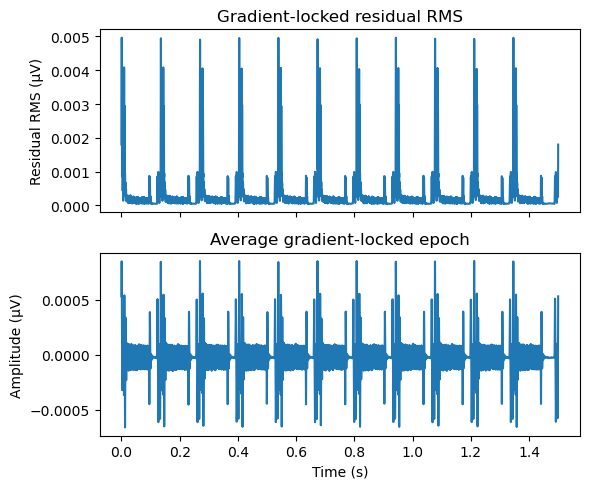

In [49]:
rms_before = gradient_locked_rms(raw.copy())

Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


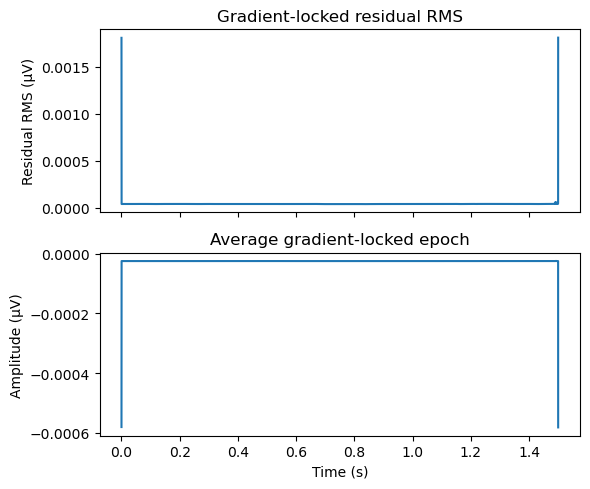

In [57]:
rms_after = gradient_locked_rms(clean_raw.copy())

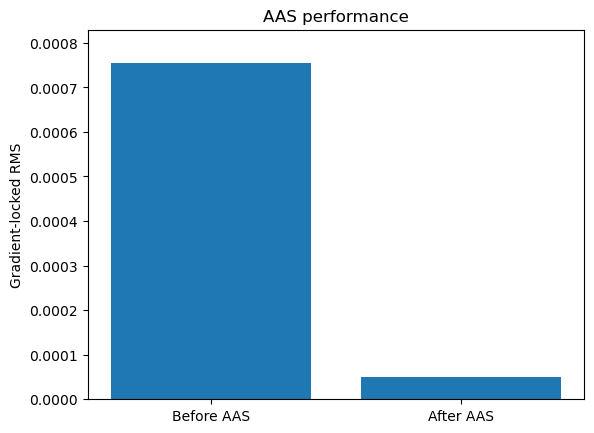

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(["Before AAS", "After AAS"], [rms_before[0], rms_after[0]])
plt.ylabel("Gradient-locked RMS")
plt.title("AAS performance")
plt.ylim(0, max(rms_before[0], rms_after[0]) * 1.1)
plt.show()


### Find optimal offest

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


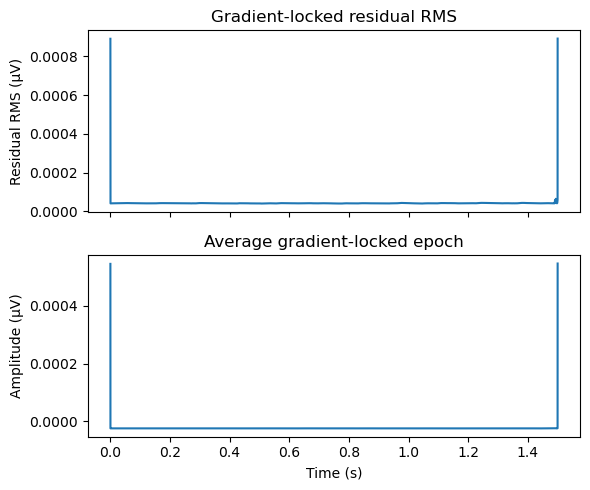

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


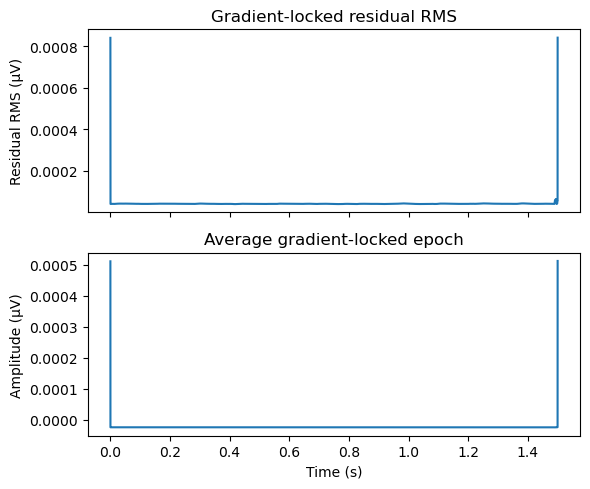

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


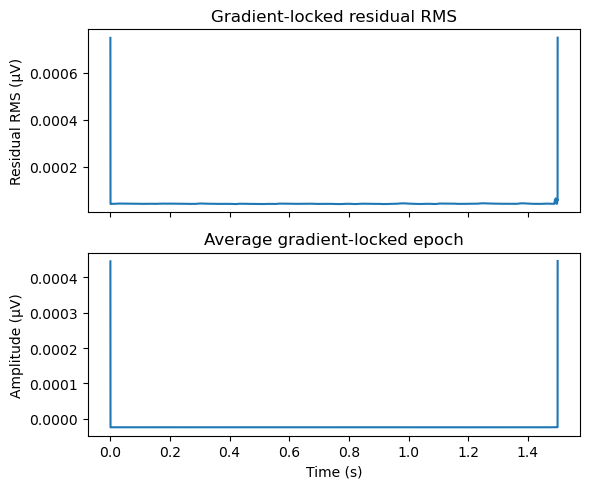

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


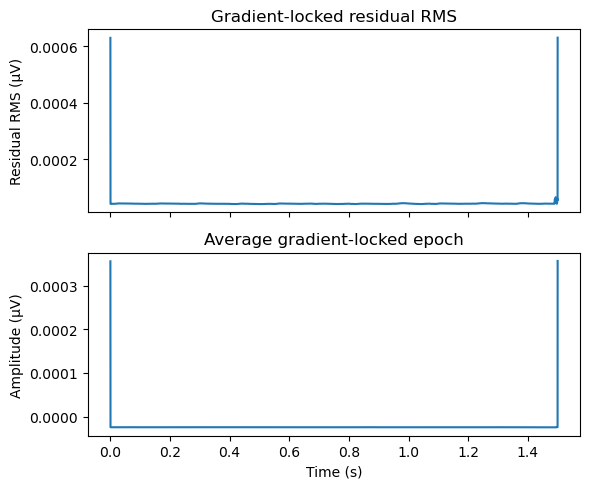

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


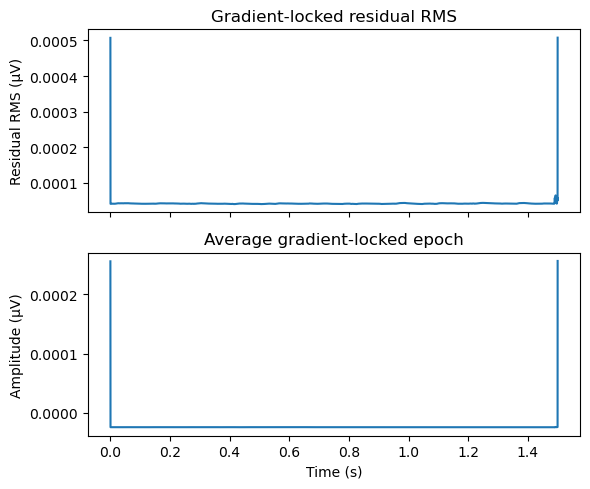

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


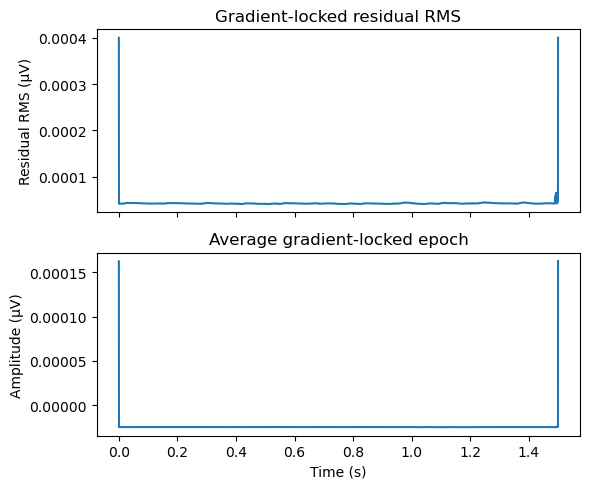

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


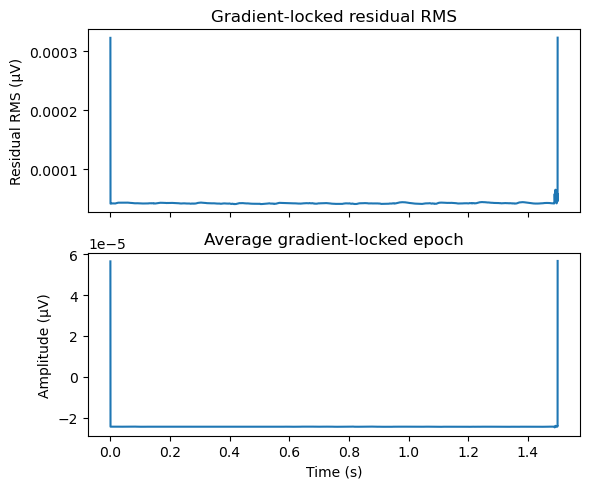

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


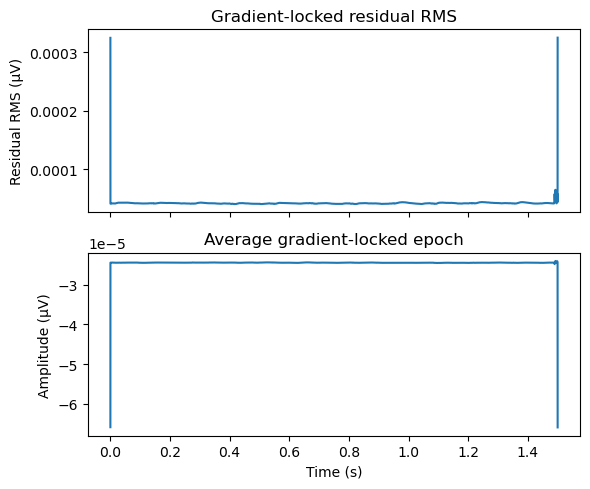

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


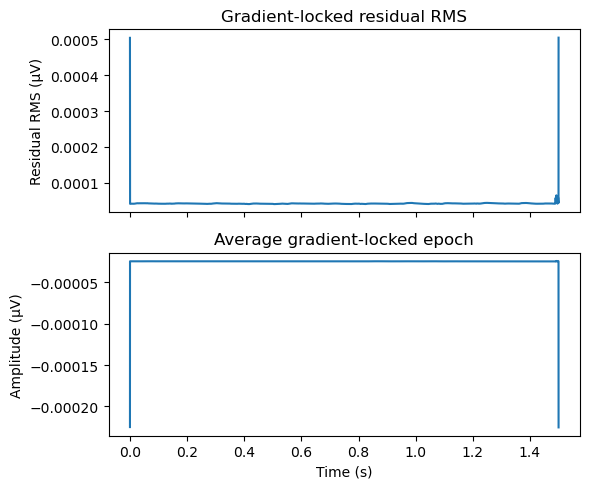

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Estimated TR: 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
(464, 63, 7501)


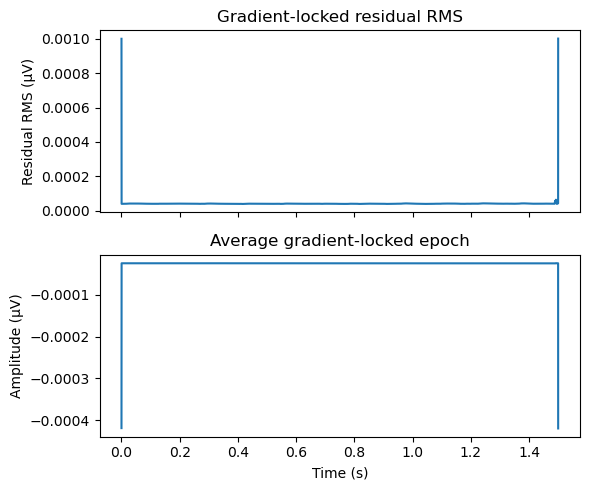

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_22516\3326163984.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped


KeyboardInterrupt: 

In [11]:
import numpy as np
# ---------- coarse grid ----------
sfreq = 5000  # Hz
step = 1 / sfreq  # seconds per sample (0.0002 s = 0.2 ms)
max_offset_ms = 2  # max ±10 ms
max_offset_s = max_offset_ms / 1000  # 10 ms → 0.01 s
coarse_offsets = np.arange(-max_offset_s, max_offset_s + step, step)


rms_values = {}

for i in coarse_offsets:
    raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)
    clean_raw = remove_gradients(raw,  window_length=61,baseline_correction=True, event_offset = i)
    rms_values[i] = gradient_locked_rms(clean_raw,event_offset = i)[0]
    

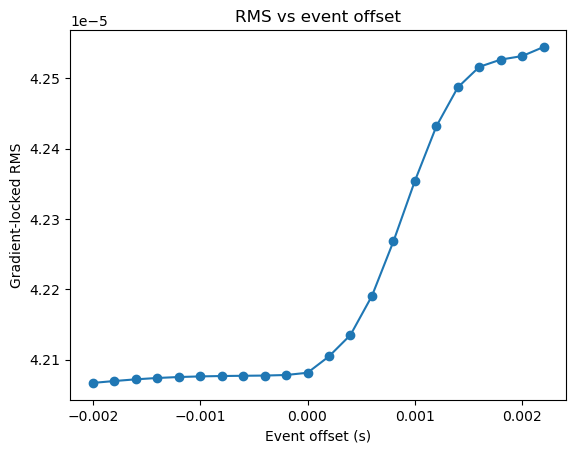

In [77]:
# Example dictionary: keys = offsets (s), values = RMS
rms_dict = rms_values  # assumed to already exist

offsets = list(rms_dict.keys())
rms_vals = list(rms_dict.values())

plt.figure()
plt.plot(offsets, rms_vals, marker="o")
plt.xlabel("Event offset (s)")
plt.ylabel("Gradient-locked RMS")
plt.title("RMS vs event offset")
plt.show()

In [135]:
import numpy as np

# parameters
min_win = 3
max_win = 61
n_points = 20  # how many different window lengths you want to test

window_lengths = np.linspace(min_win, max_win, n_points, dtype=int)

rms_values = {}

for i in window_lengths:
    raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)
    clean_raw = remove_gradients(raw,  window_length=i,baseline_correction=True)
    rms_values[i] = gradient_locked_rms(clean_raw)
    

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Window length must be odd. Window length is now 7
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Window length must be odd. Window length is now 13
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Window length must be odd. Window length is now 19
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Window length must be odd. Window length is now 25
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Window length must be odd. Window length is now 31
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Window length must be odd. Window length is now 37
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Window length must be odd. Window length is now 43
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Window length must be odd. Window length is now 49
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Window length must be odd. Window length is now 55
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_29208\3455188801.py:13: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped
Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7501 original time points ...
0 bad epochs dropped


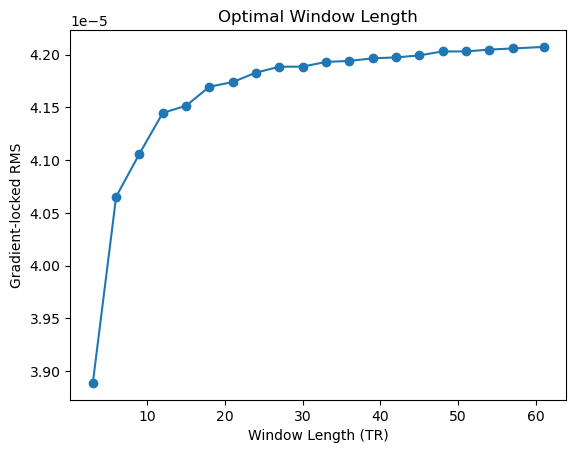

In [136]:
# Example dictionary: keys = offsets (s), values = RMS
rms_dict = rms_values  # assumed to already exist

offsets = list(rms_dict.keys())
rms_vals = list(rms_dict.values())

plt.figure()
plt.plot(offsets, rms_vals, marker="o")
plt.xlabel("Window Length (TR)")
plt.ylabel("Gradient-locked RMS")
plt.title("Optimal Window Length")
plt.show()

## R peak Detection

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks

# --- 1. Detect T-wave peaks in A6 component ---
def detect_A6_peaks(signal, fs, wavelet='db4', level_max=6, height_factor=1.5):
    """
    Detect peaks in A6 wavelet component of ECG.
    """
    max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
    level = min(level_max, max_level)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    A6 = coeffs[0]
    A6_rec = pywt.waverec([A6] + [np.zeros_like(c) for c in coeffs[1:]], wavelet)[:len(signal)]
    
    peaks, _ = find_peaks(
        A6_rec, 
        distance=int(0.2*fs),  # min 200ms between T-waves
        height=np.mean(A6_rec) + height_factor*np.std(A6_rec)
    )
    
    return peaks, A6_rec

# --- 2. Find preceding peak (likely R-peak) for each T-wave ---
def find_preceding_peaks(signal, t_peaks, fs):
    """
    For each T-wave peak, find the preceding peak in the original ECG.
    """
    r_peaks, _ = find_peaks(signal, distance=int(0.2*fs))  # avoid double-counting R-peaks
    
    preceding_peaks = []
    for t in t_peaks:
        candidates = r_peaks[r_peaks < t]
        if len(candidates) > 0:
            preceding_peaks.append(candidates[-1])
        else:
            preceding_peaks.append(None)
    
    return np.array(preceding_peaks)

# --- 3. Suppress T-waves using local blending ---
def suppress_Twaves(signal, time, t_peaks, fs, half_window=0.175, pad_fraction=0.175):
    """
    Suppress T-waves around detected peaks using local blending.
    Anchors window on T-wave, can be extended based on physiological reference.
    """
    ecg_clean = signal.copy()
    pad_samples = int(pad_fraction * fs)
    
    for p in t_peaks:
        start_idx = max(0, np.searchsorted(time, time[p] - half_window))
        end_idx   = min(len(signal), np.searchsorted(time, time[p] + half_window))
        
        left = max(0, start_idx - pad_samples)
        right = min(len(signal), end_idx + pad_samples)
        
        # Linear interpolation across the window
        interp_values = np.linspace(ecg_clean[left], ecg_clean[right-1], end_idx - start_idx)
        
        # Blend with moving average of neighbors
        blend_window = max(int(pad_samples/2), 1)
        ma_left = np.convolve(ecg_clean[left:start_idx], np.ones(blend_window)/blend_window, mode='same') if start_idx>left else []
        ma_right = np.convolve(ecg_clean[end_idx:right], np.ones(blend_window)/blend_window, mode='same') if right>end_idx else []
        
        if len(ma_left) > 0:
            interp_values[:len(ma_left)] = (interp_values[:len(ma_left)] + ma_left)/2
        if len(ma_right) > 0:
            interp_values[-len(ma_right):] = (interp_values[-len(ma_right):] + ma_right)/2
        
        ecg_clean[start_idx:end_idx] = interp_values
        
    return ecg_clean

# --- 4. Plot ECG with T-wave suppression ---
def plot_ecg(time, original, cleaned, t_peaks, half_window=0.15):
    plt.figure(figsize=(12,5))
    plt.plot(time, original, label='Original ECG', alpha=0.5)
    plt.plot(time, cleaned, label='T-wave suppressed', color='tab:blue')
    plt.plot(time[t_peaks], original[t_peaks], 'ro', label='Detected T-wave peaks')
    for p in t_peaks:
        plt.axvspan(time[p] - half_window, time[p] + half_window, color='orange', alpha=0.2)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("ECG with T-wave suppression")
    plt.legend()
    plt.show()


    import numpy as np

def lookback_max(signal, fs, window_ms=200):
    """
    Find the maximum in a look-back window of size window_ms for the signal.
    
    Parameters
    ----------
    signal : np.ndarray
        1D ECG signal
    fs : float
        Sampling frequency in Hz
    window_ms : float
        Look-back window in milliseconds

    Returns
    -------
    peak_indices : list
        Indices of the peak (max) in each window
    peak_values : list
        Corresponding peak values
    """
    window_samples = int(window_ms/1000 * fs)
    peak_indices = []
    peak_values = []

    for i in range(window_samples, len(signal)):
        window = signal[i-window_samples:i]  # look-back window
        local_max_idx = np.argmax(window)
        peak_idx = i - window_samples + local_max_idx
        peak_indices.append(peak_idx)
        peak_values.append(signal[peak_idx])

    return np.array(peak_indices), np.array(peak_values)


In [9]:
raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)
clean_raw = remove_gradients(raw,  window_length=61,baseline_correction=True)

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_38564\1865514005.py:1: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...


C:\Users\brand\AppData\Local\Temp\ipykernel_38564\1865514005.py:1: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


0 bad epochs dropped


In [10]:
ecg_data = clean_raw.pick('ECG')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)



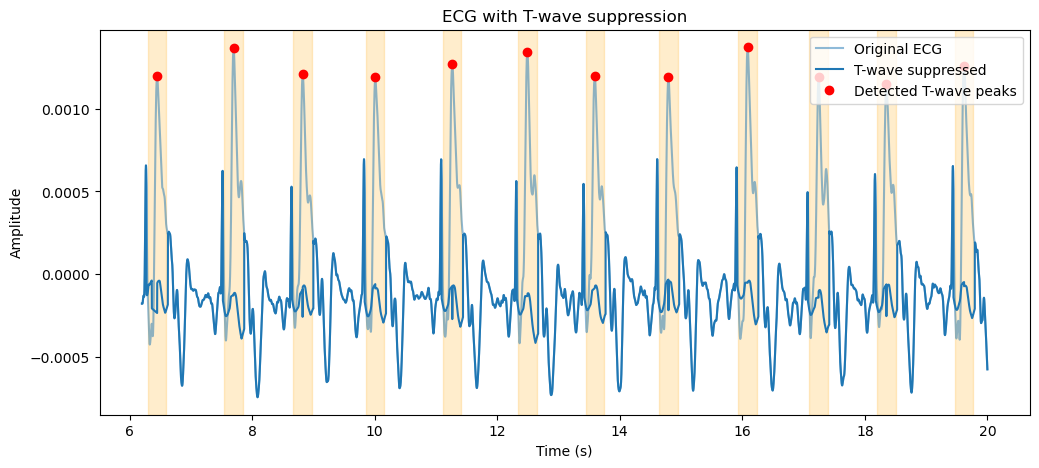

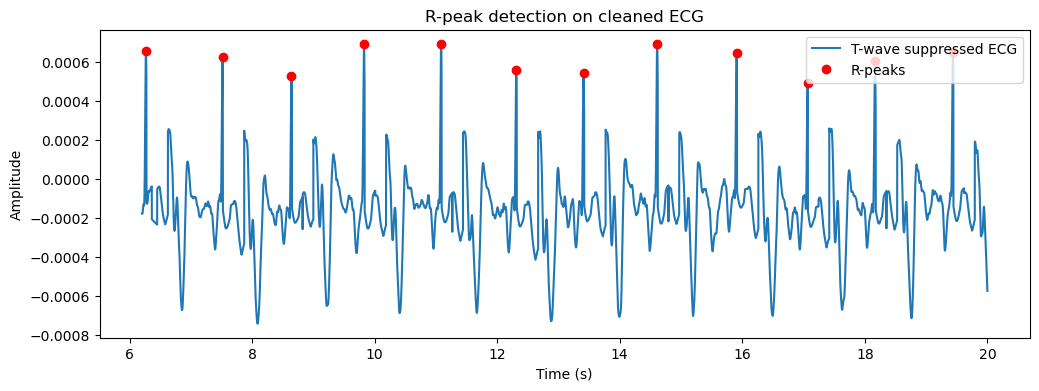

In [28]:
# --- Main workflow ---
raw_ecg = ecg_data.copy().filter(1,30, picks='ECG')
signal = raw_ecg.get_data()[0][31000:100000]
time = ecg_data.times[31000:100000]
dt = np.mean(np.diff(time))
fs = 1 / dt

# Detect A6 peaks
peaks_A6, A6_rec = detect_A6_peaks(signal, fs)

R_peaks = find_preceding_peaks(signal, peaks_A6, fs)

# Suppress T-waves
ecg_clean = suppress_Twaves(signal, time, peaks_A6, fs)

# Plot
plot_ecg(time, signal, ecg_clean, peaks_A6)

# --- Now detect R-peaks on cleaned ECG ---
#R_peaks, _ = find_peaks(ecg_clean, distance=int(0.05*fs), height=np.mean(ecg_clean) + 3*np.std(ecg_clean))

lookback_ms = 1000
lookback_samples = int(lookback_ms / 5000 * fs)

R_peaks = np.array([t - lookback_samples + np.argmax(ecg_clean[max(0, t - lookback_samples):t]) 
                    for t in peaks_A6])



# Plot cleaned ECG with R-peaks
plt.figure(figsize=(12,4))
plt.plot(time, ecg_clean, label='T-wave suppressed ECG')
plt.plot(time[R_peaks], ecg_clean[R_peaks], 'ro', label='R-peaks')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("R-peak detection on cleaned ECG")
plt.legend()
plt.show()

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)



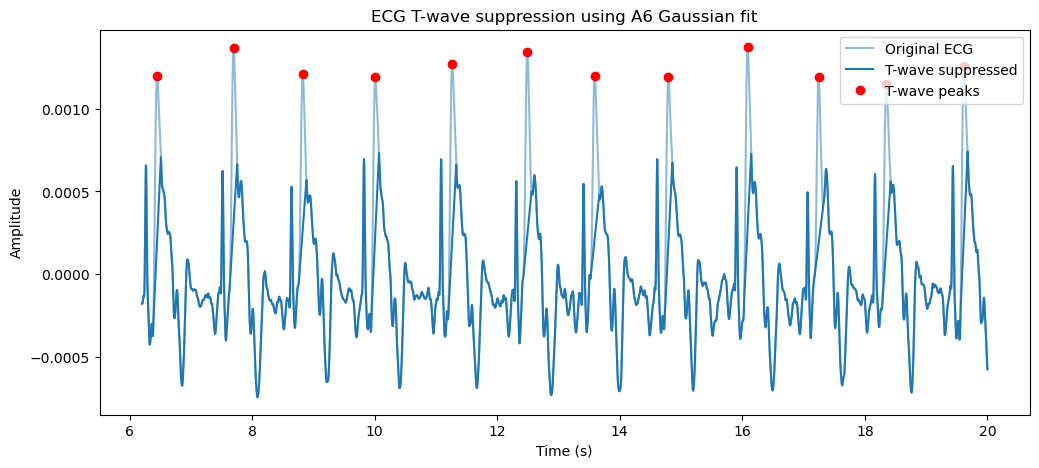

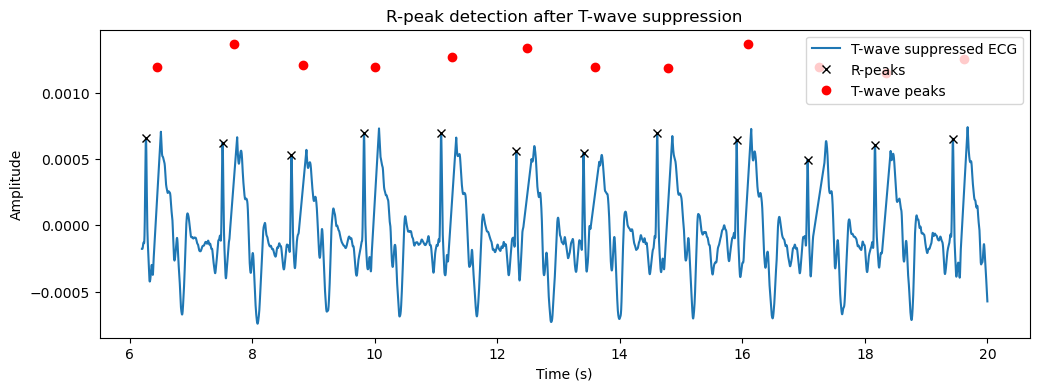

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# --- Wavelet-based T-wave detection ---
def detect_A6_peaks(signal, fs, wavelet='db4', level_max=6, height_factor=1.5):
    """Detect T-wave peaks using A6 wavelet component."""
    max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
    level = min(level_max, max_level)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    A6 = coeffs[0]
    A6_rec = pywt.waverec([A6] + [np.zeros_like(c) for c in coeffs[1:]], wavelet)[:len(signal)]

    peaks, _ = find_peaks(A6_rec, distance=int(0.2*fs),
                           height=np.mean(A6_rec) + height_factor*np.std(A6_rec))
    return peaks, A6_rec

# --- Gaussian function ---
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

# --- Suppress T-waves dynamically based on A6 fitting ---
def suppress_Twaves(signal, A6_rec, peaks_A6, fs, fit_window_ms=500, pad_fraction=0.1):
    """
    Suppress T-waves in raw ECG using peak + width from A6 Gaussian fit.

    Parameters
    ----------
    signal : np.ndarray
        Raw ECG signal
    A6_rec : np.ndarray
        Reconstructed A6 component
    peaks_A6 : np.ndarray
        Indices of T-wave peaks in A6
    fs : float
        Sampling rate
    fit_window_ms : float
        Look-back and forward window around T-wave for fitting
    pad_fraction : float
        Fraction of width to pad the suppression window

    Returns
    -------
    ecg_clean : np.ndarray
        ECG with T-wave suppressed
    """
    ecg_clean = signal.copy()
    fit_window_samples = int(fit_window_ms / 1000 * fs)

    for t in peaks_A6:
        start = max(0, t - fit_window_samples)
        end = min(len(A6_rec), t + fit_window_samples)
        x = np.arange(start, end)
        y = A6_rec[start:end]

        # initial guesses: amplitude, center, width
        p0 = [A6_rec[t], t, 0.05*fs]

        try:
            popt, _ = curve_fit(gaussian, x, y, p0=p0)
            a, mu, sigma = popt
            # Convert width to samples for suppression
            width_samples = int(2 * np.sqrt(2 * np.log(2)) * sigma)
        except:
            width_samples = fit_window_samples  # fallback

        # define suppression window
        half_win = int(width_samples * (1 + pad_fraction) / 2)
        w_start = max(0, t - half_win)
        w_end = min(len(signal), t + half_win)

        # linear interpolation to suppress T-wave
        ecg_clean[w_start:w_end] = np.linspace(ecg_clean[w_start], ecg_clean[w_end-1], w_end - w_start)

    return ecg_clean

# --- Main workflow using provided data ---
raw_ecg = ecg_data.copy().filter(1,30, picks='ECG')
signal = raw_ecg.get_data()[0][31000:100000]
time = ecg_data.times[31000:100000]
dt = np.mean(np.diff(time))
fs = 1 / dt

# Detect T-wave peaks
peaks_A6, A6_rec = detect_A6_peaks(signal, fs)

# Suppress T-waves dynamically
ecg_clean = suppress_Twaves(signal, A6_rec, peaks_A6, fs)

# Plot results
plt.figure(figsize=(12,5))
plt.plot(time, signal, label='Original ECG', alpha=0.5)
plt.plot(time, ecg_clean, label='T-wave suppressed', color='tab:blue')
plt.plot(time[peaks_A6], signal[peaks_A6], 'ro', label='T-wave peaks')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG T-wave suppression using A6 Gaussian fit")
plt.legend()
plt.show()

# --- Detect R-peaks as preceding peak to each T-wave ---
lookback_ms = 200
lookback_samples = int(lookback_ms / 1000 * fs)
R_peaks = np.array([t - lookback_samples + np.argmax(ecg_clean[max(0, t - lookback_samples):t]) 
                    for t in peaks_A6])

# Plot cleaned ECG with R-peaks
plt.figure(figsize=(12,4))
plt.plot(time, ecg_clean, label='T-wave suppressed ECG')
plt.plot(time[R_peaks], ecg_clean[R_peaks], 'kx', label='R-peaks')
plt.plot(time[peaks_A6], signal[peaks_A6], 'ro', label='T-wave peaks')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("R-peak detection after T-wave suppression")
plt.legend()
plt.show()


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)



C:\Users\brand\AppData\Local\Temp\ipykernel_38564\3676304527.py:24: RuntimeWarning: invalid value encountered in divide
  return baseline + height * pdf_vals / np.max(pdf_vals)


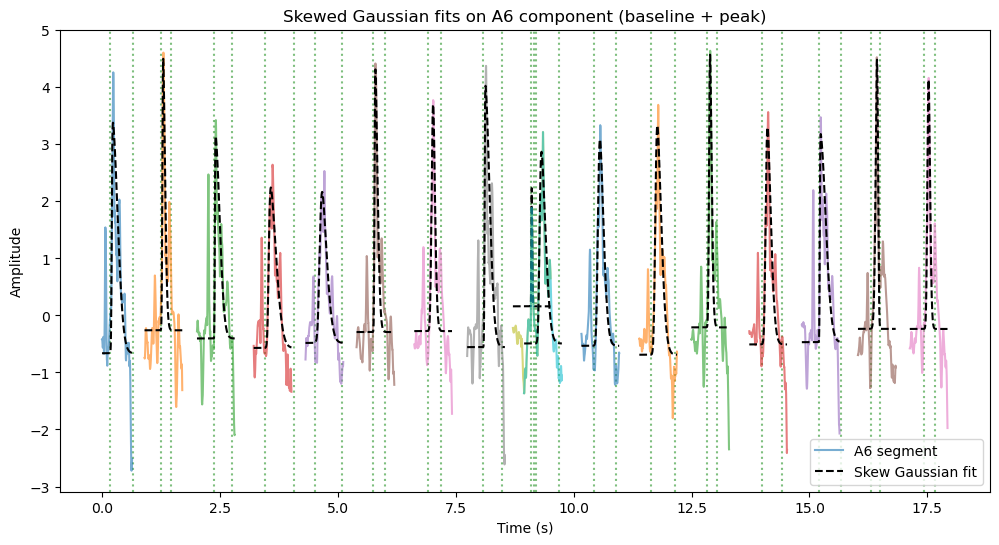

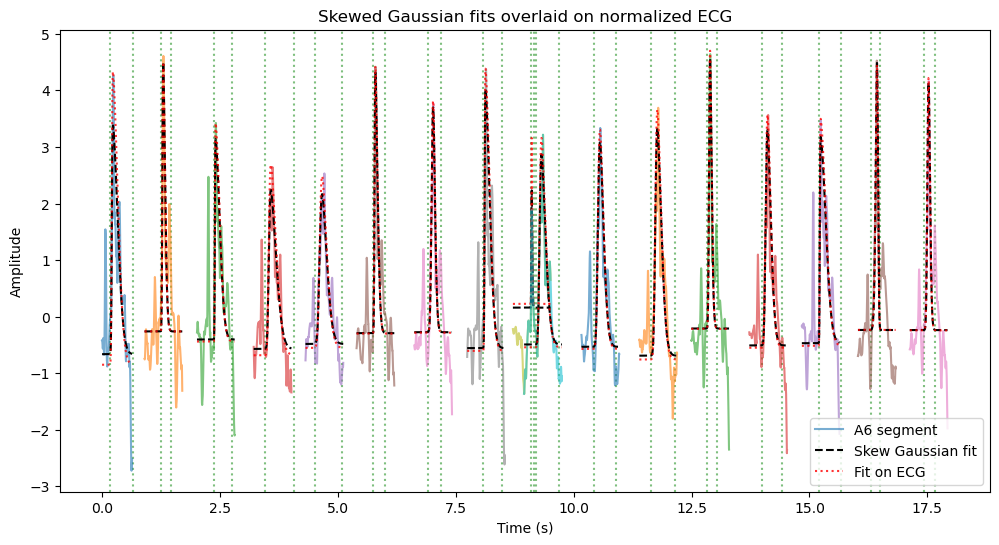

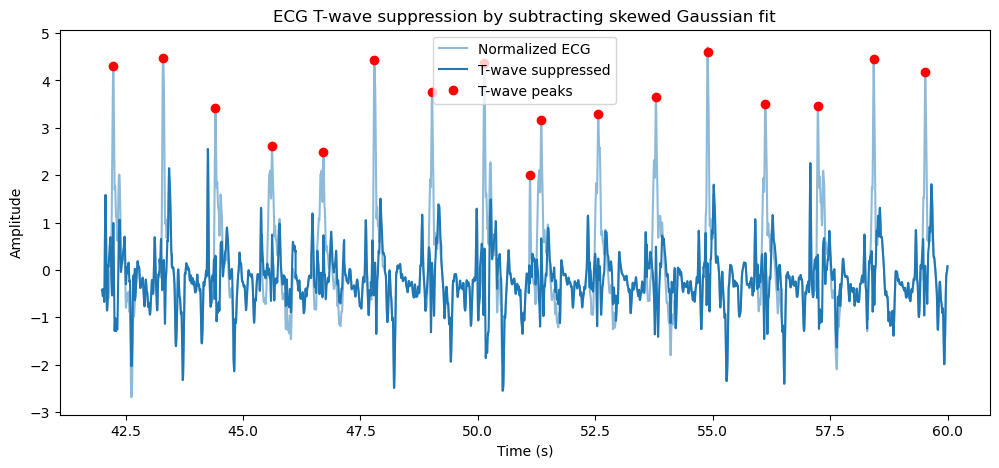

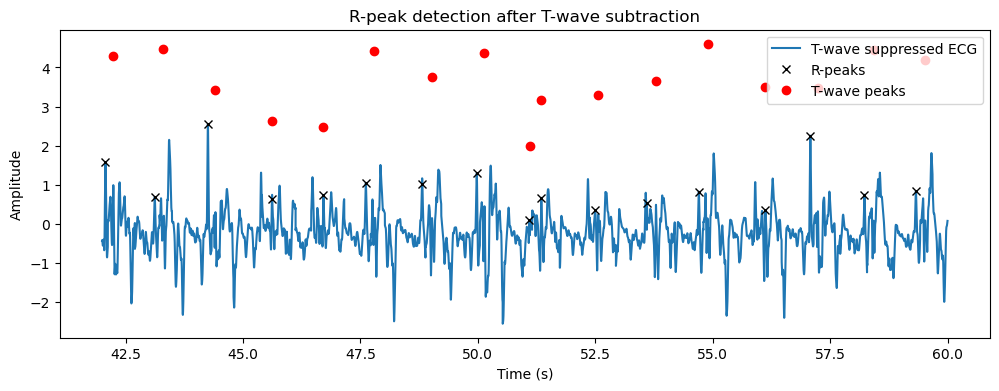

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
from functools import partial

# --- Wavelet-based T-wave detection ---
def detect_A6_peaks(signal, fs, wavelet='db4', level_max=6, height_factor=1.5):
    max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
    level = min(level_max, max_level)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    A6 = coeffs[0]
    A6_rec = pywt.waverec([A6] + [np.zeros_like(c) for c in coeffs[1:]], wavelet)[:len(signal)]

    peaks, _ = find_peaks(A6_rec, distance=int(0.2*fs),
                           height=np.mean(A6_rec) + height_factor*np.std(A6_rec))
    return peaks, A6_rec

# --- Skewed Gaussian with baseline and true peak height ---
def skewed_gaussian_peak_scaled(x, mu, sigma, alpha, baseline, height):
    pdf_vals = skewnorm.pdf(x, alpha, loc=mu, scale=sigma)
    return baseline + height * pdf_vals / np.max(pdf_vals)

# --- Compute width at near-baseline ---
def skewed_gaussian_width_baseline(popt, threshold_fraction=1e-3):
    mu, sigma, alpha, baseline = popt
    x_dense = np.linspace(mu - 10*sigma, mu + 10*sigma, 10000)
    y_dense = skewed_gaussian_peak_scaled(x_dense, *popt, height=1)  # normalized
    threshold = baseline + threshold_fraction
    indices = np.where(y_dense > threshold)[0]
    if len(indices) == 0:
        return 0, mu, mu
    left_x = x_dense[indices[0]]
    right_x = x_dense[indices[-1]]
    width = right_x - left_x
    return width, left_x, right_x

# --- Plot T-wave fits ---
def plot_Twave_fits(signal_to_plot, A6_rec, peaks_A6, fs, fit_window_ms=400, title=""):
    fit_window_samples = int(fit_window_ms / 1000 * fs)
    plt.figure(figsize=(12,6))

    for t in peaks_A6:
        start = max(0, t - fit_window_samples)
        end = min(len(A6_rec), t + fit_window_samples)
        x = np.arange(start, end)
        y = A6_rec[start:end]

        baseline_guess = np.median(A6_rec[start:end])
        height = A6_rec[t] - baseline_guess

        fit_func = partial(skewed_gaussian_peak_scaled, height=height)
        p0 = [t, 0.05*fs, 0, baseline_guess]

        try:
            popt, _ = curve_fit(fit_func, x, y, p0=p0)
            y_fit = fit_func(x, *popt)
            # visualize baseline width
            _, left_x, right_x = skewed_gaussian_width_baseline(popt)
            plt.axvline(left_x/fs, color='green', linestyle=':', alpha=0.5)
            plt.axvline(right_x/fs, color='green', linestyle=':', alpha=0.5)
        except:
            y_fit = np.zeros_like(y)

        plt.plot(x/fs, y, alpha=0.6, label="A6 segment" if t==peaks_A6[0] else "")
        plt.plot(x/fs, y_fit, '--', color='black', label="Skew Gaussian fit" if t==peaks_A6[0] else "")

        if signal_to_plot is not None:
            scale_factor = np.max(signal_to_plot[start:end]) / np.max(y_fit)
            plt.plot(x/fs, y_fit * scale_factor, ':', color='red', alpha=0.8, label="Fit on ECG" if t==peaks_A6[0] else "")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    plt.show()

# --- Suppress T-waves by subtracting the skewed Gaussian fit ---
def suppress_Twaves_subtract(signal, A6_rec, peaks_A6, fs, fit_window_ms=400, pad_fraction=0.1):
    ecg_clean = signal.copy()
    fit_window_samples = int(fit_window_ms / 1000 * fs)

    for t in peaks_A6:
        # initial window for fitting
        start_fit = max(0, t - fit_window_samples)
        end_fit = min(len(A6_rec), t + fit_window_samples)
        x_fit = np.arange(start_fit, end_fit)
        y_fit_data = A6_rec[start_fit:end_fit]

        baseline_guess = np.median(A6_rec[start_fit:end_fit])
        height = A6_rec[t] - baseline_guess

        fit_func = partial(skewed_gaussian_peak_scaled, height=height)
        p0 = [t, 0.05*fs, 0, baseline_guess]

        try:
            # Fit the skewed Gaussian
            popt, _ = curve_fit(fit_func, x_fit, y_fit_data, p0=p0)

            # Determine baseline width
            _, left_x, right_x = skewed_gaussian_width_baseline(popt)
            w_start = max(0, int(left_x))
            w_end = min(len(signal), int(right_x))

            # Add optional padding
            pad = int(pad_fraction * (w_end - w_start))
            w_start = max(0, w_start - pad)
            w_end = min(len(signal), w_end + pad)

            # Generate skewed Gaussian over the exact suppression window
            x_window = np.arange(w_start, w_end)
            y_fit_window = skewed_gaussian_peak_scaled(x_window, *popt, height=height)

            # Subtract the skewed Gaussian fit
            ecg_clean[w_start:w_end] -= y_fit_window

        except:
            pass  # if fit fails, leave ECG unchanged

    return ecg_clean

# --- Main workflow ---
# raw_ecg should be an MNE Raw object with ECG channel
raw_ecg = ecg_data.copy().filter(1,30, picks='ECG')  # replace ecg_data with your MNE Raw
signal = raw_ecg.get_data()[0][210000:300000]
time = raw_ecg.times[210000:300000]
dt = np.mean(np.diff(time))
fs = 1 / dt

# Normalize ECG
signal = (signal - np.mean(signal)) / np.std(signal)

# Detect T-wave peaks
peaks_A6, A6_rec = detect_A6_peaks(signal, fs)

# Plot fits on A6
plot_Twave_fits(None, A6_rec, peaks_A6, fs, title="Skewed Gaussian fits on A6 component (baseline + peak)")

# Plot fits over normalized ECG
plot_Twave_fits(signal, A6_rec, peaks_A6, fs, title="Skewed Gaussian fits overlaid on normalized ECG")

# Suppress T-waves by subtracting the fit
ecg_clean = suppress_Twaves_subtract(signal, A6_rec, peaks_A6, fs)

# Plot original vs cleaned ECG
plt.figure(figsize=(12,5))
plt.plot(time, signal, label='Normalized ECG', alpha=0.5)
plt.plot(time, ecg_clean, label='T-wave suppressed', color='tab:blue')
plt.plot(time[peaks_A6], signal[peaks_A6], 'ro', label='T-wave peaks')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG T-wave suppression by subtracting skewed Gaussian fit")
plt.legend()
plt.show()

# Detect R-peaks after T-wave suppression
lookback_ms = 200
lookback_samples = int(lookback_ms / 1000 * fs)
R_peaks = np.array([t - lookback_samples + np.argmax(ecg_clean[max(0, t - lookback_samples):t])
                    for t in peaks_A6])

# Plot cleaned ECG with R-peaks
plt.figure(figsize=(12,4))
plt.plot(time, ecg_clean, label='T-wave suppressed ECG')
plt.plot(time[R_peaks], ecg_clean[R_peaks], 'kx', label='R-peaks')
plt.plot(time[peaks_A6], signal[peaks_A6], 'ro', label='T-wave peaks')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("R-peak detection after T-wave subtraction")
plt.legend()
plt.show()


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)



C:\Users\brand\AppData\Local\Temp\ipykernel_38564\3429877399.py:24: RuntimeWarning: invalid value encountered in divide
  return baseline + height * pdf_vals / np.max(pdf_vals)
C:\Users\brand\AppData\Local\Temp\ipykernel_38564\3429877399.py:58: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fit_func, x_local, y, p0=p0)


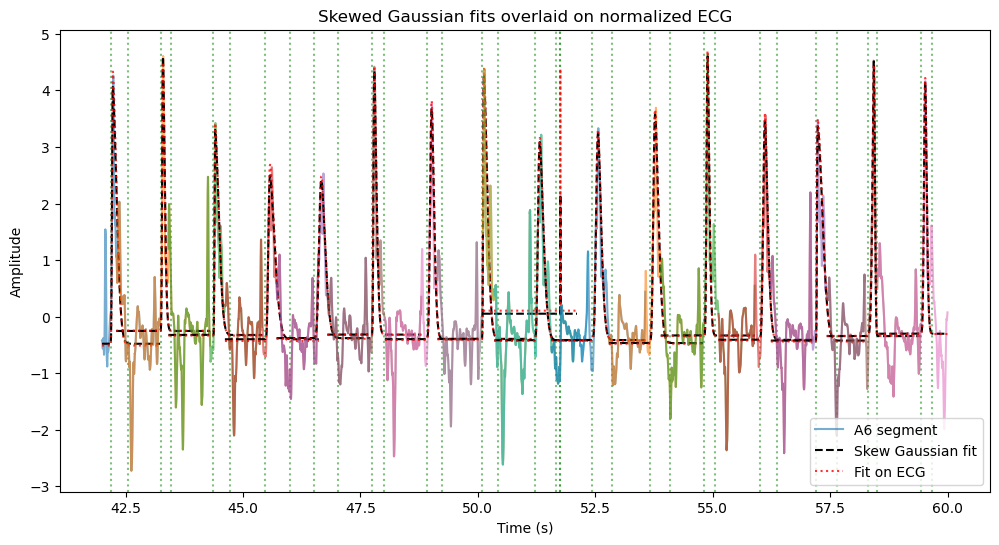

C:\Users\brand\AppData\Local\Temp\ipykernel_38564\3429877399.py:94: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fit_func, np.arange(start, end), A6_rec[start:end], p0=p0)
C:\Users\brand\AppData\Local\Temp\ipykernel_38564\3429877399.py:164: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fit_func, x_local, y, p0=[t, 0.05*fs, 0, baseline_guess])


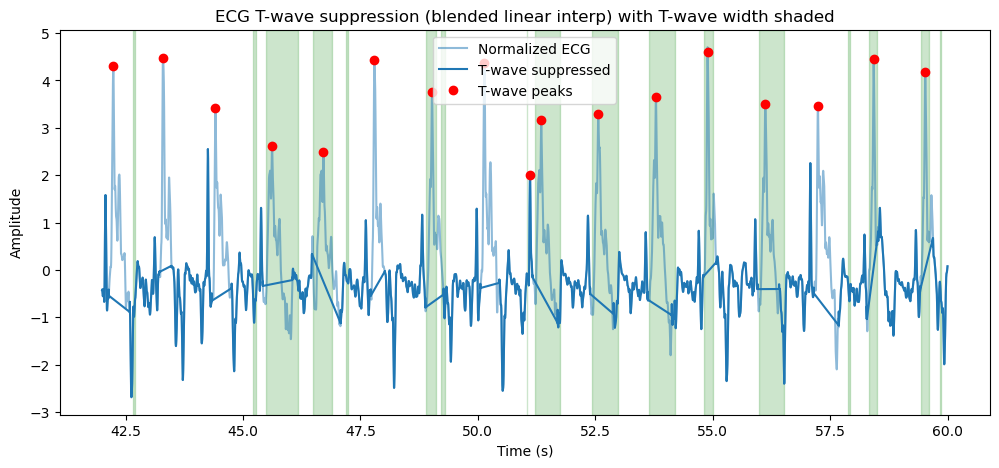

C:\Users\brand\AppData\Local\Temp\ipykernel_38564\3429877399.py:198: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fit_func, x_local, y, p0=[t, 0.05*fs, 0, baseline_guess])


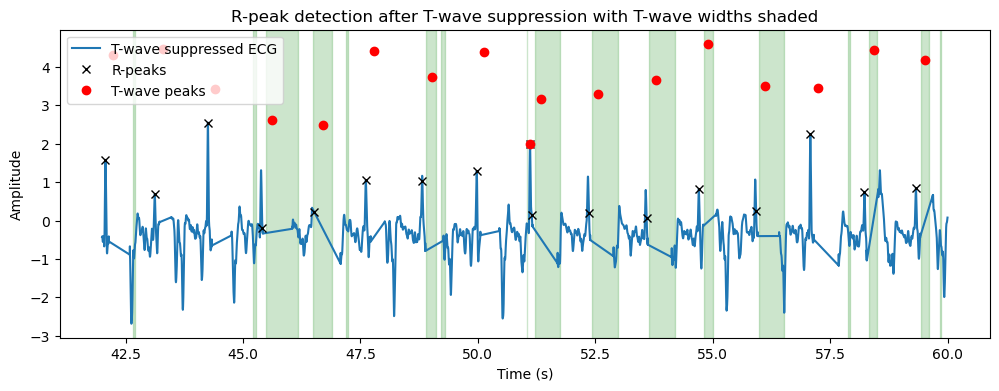

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
from functools import partial

# --- Wavelet-based T-wave detection ---
def detect_A6_peaks(signal, fs, wavelet='db4', level_max=6, height_factor=1.5):
    max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
    level = min(level_max, max_level)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    A6 = coeffs[0]
    A6_rec = pywt.waverec([A6] + [np.zeros_like(c) for c in coeffs[1:]], wavelet)[:len(signal)]

    peaks, _ = find_peaks(A6_rec, distance=int(0.2*fs),
                           height=np.mean(A6_rec) + height_factor*np.std(A6_rec))
    return peaks, A6_rec

# --- Skewed Gaussian with baseline and true peak height ---
def skewed_gaussian_peak_scaled(x, mu, sigma, alpha, baseline, height):
    pdf_vals = skewnorm.pdf(x, alpha, loc=mu, scale=sigma)
    return baseline + height * pdf_vals / np.max(pdf_vals)

# --- Compute width at near-baseline ---
def skewed_gaussian_width_baseline(popt, threshold_fraction=1e-3):
    mu, sigma, alpha, baseline = popt
    x_dense = np.linspace(mu - 10*sigma, mu + 10*sigma, 10000)
    y_dense = skewed_gaussian_peak_scaled(x_dense, *popt, height=1)
    threshold = baseline + threshold_fraction
    indices = np.where(y_dense > threshold)[0]
    if len(indices) == 0:
        return 0, mu, mu
    left_x = x_dense[indices[0]]
    right_x = x_dense[indices[-1]]
    width = right_x - left_x
    return width, left_x, right_x

# --- Plot T-wave fits ---
def plot_Twave_fits(signal_to_plot, A6_rec, peaks_A6, time, fs, fit_window_ms=1000, title=""):
    fit_window_samples = int(fit_window_ms / 1000 * fs)
    plt.figure(figsize=(12,6))

    for t in peaks_A6:
        start = max(0, t - fit_window_samples)
        end = min(len(A6_rec), t + fit_window_samples)
        x_local = np.arange(start, end)
        y = A6_rec[start:end]

        baseline_guess = np.median(y)
        height = A6_rec[t] - baseline_guess

        fit_func = partial(skewed_gaussian_peak_scaled, height=height)
        p0 = [t, 0.05*fs, 0, baseline_guess]

        try:
            popt, _ = curve_fit(fit_func, x_local, y, p0=p0)
            y_fit = fit_func(x_local, *popt)
            _, left_x, right_x = skewed_gaussian_width_baseline(popt)
            plt.axvline(time[int(left_x)], color='green', linestyle=':', alpha=0.5)
            plt.axvline(time[int(right_x)], color='green', linestyle=':', alpha=0.5)
        except:
            y_fit = np.zeros_like(y)

        plt.plot(time[start:end], y, alpha=0.6, label="A6 segment" if t==peaks_A6[0] else "")
        plt.plot(time[start:end], y_fit, '--', color='black', label="Skew Gaussian fit" if t==peaks_A6[0] else "")
        if signal_to_plot is not None:
            scale_factor = np.max(signal_to_plot[start:end]) / np.max(y_fit)
            plt.plot(time[start:end], y_fit * scale_factor, ':', color='red', alpha=0.8, label="Fit on ECG" if t==peaks_A6[0] else "")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    plt.show()

# --- Suppress T-waves using blended linear interpolation ---
def suppress_Twaves_blend(signal, A6_rec, peaks_A6, fs, fit_window_ms=1000, pad_fraction=0.1, blend_window_samples=10):
    ecg_clean = signal.copy()
    fit_window_samples = int(fit_window_ms / 1000 * fs)

    for t in peaks_A6:
        start = max(0, t - fit_window_samples)
        end = min(len(A6_rec), t + fit_window_samples)

        baseline_guess = np.median(A6_rec[start:end])
        height = A6_rec[t] - baseline_guess

        fit_func = partial(skewed_gaussian_peak_scaled, height=height)
        p0 = [t, 0.05*fs, 0, baseline_guess]

        try:
            popt, _ = curve_fit(fit_func, np.arange(start, end), A6_rec[start:end], p0=p0)
            _, left_x, right_x = skewed_gaussian_width_baseline(popt)
            left = max(0, int(left_x))
            right = min(len(signal), int(right_x))

            # Add optional padding
            pad = int(pad_fraction * (right - left))
            start_idx = max(0, left - pad)
            end_idx = min(len(signal), right + pad)

            # Linear interpolation across the T-wave window
            interp_values = np.linspace(ecg_clean[start_idx], ecg_clean[end_idx-1], end_idx - start_idx)

            # Blend with moving average of neighbors
            ma_left = np.convolve(ecg_clean[max(0,start_idx-blend_window_samples):start_idx],
                                  np.ones(blend_window_samples)/blend_window_samples, mode='same') if start_idx>0 else []
            ma_right = np.convolve(ecg_clean[end_idx:min(len(signal),end_idx+blend_window_samples)],
                                   np.ones(blend_window_samples)/blend_window_samples, mode='same') if end_idx<len(signal) else []

            if len(ma_left)>0:
                interp_values[:len(ma_left)] = (interp_values[:len(ma_left)] + ma_left)/2
            if len(ma_right)>0:
                interp_values[-len(ma_right):] = (interp_values[-len(ma_right):] + ma_right)/2

            ecg_clean[start_idx:end_idx] = interp_values

        except:
            pass

    return ecg_clean

# --- MAIN WORKFLOW ---
# Replace `ecg_data` with your MNE Raw object containing ECG channel
raw_ecg = ecg_data.copy().filter(1,30, picks='ECG')
signal = raw_ecg.get_data()[0][210000:300000]
time = raw_ecg.times[210000:300000]
dt = np.mean(np.diff(time))
fs = 1 / dt

# Normalize ECG
signal = (signal - np.mean(signal)) / np.std(signal)

# Detect T-wave peaks
peaks_A6, A6_rec = detect_A6_peaks(signal, fs)

# Plot fits on A6
#plot_Twave_fits(None, A6_rec, peaks_A6, time, fs, title="Skewed Gaussian fits on A6 component")

# Plot fits over normalized ECG
plot_Twave_fits(signal, A6_rec, peaks_A6, time, fs, title="Skewed Gaussian fits overlaid on normalized ECG")

# Suppress T-waves with blended linear interpolation
ecg_clean = suppress_Twaves_blend(signal, A6_rec, peaks_A6, fs)

# --- Plot original vs cleaned ECG with T-wave width shading ---
plt.figure(figsize=(12,5))
plt.plot(time, signal, label='Normalized ECG', alpha=0.5)
plt.plot(time, ecg_clean, label='T-wave suppressed', color='tab:blue')
plt.plot(time[peaks_A6], signal[peaks_A6], 'ro', label='T-wave peaks')

# Shade T-wave widths
for t in peaks_A6:
    start = max(0, t - int(0.2*fs))
    end = min(len(A6_rec), t + int(0.2*fs))
    x_local = np.arange(start, end)
    y = A6_rec[start:end]
    baseline_guess = np.median(y)
    height = A6_rec[t] - baseline_guess
    fit_func = partial(skewed_gaussian_peak_scaled, height=height)
    try:
        popt, _ = curve_fit(fit_func, x_local, y, p0=[t, 0.05*fs, 0, baseline_guess])
        _, left_x, right_x = skewed_gaussian_width_baseline(popt)
        plt.axvspan(time[int(left_x)], time[int(right_x)], color='green', alpha=0.2)
    except:
        continue

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG T-wave suppression (blended linear interp) with T-wave width shaded")
plt.legend()
plt.show()

# --- Detect R-peaks after T-wave suppression ---
lookback_ms = 200
lookback_samples = int(lookback_ms / 1000 * fs)
R_peaks = np.array([t - lookback_samples + np.argmax(ecg_clean[max(0, t - lookback_samples):t])
                    for t in peaks_A6])

# --- Plot cleaned ECG with R-peaks and shaded T-wave widths ---
plt.figure(figsize=(12,4))
plt.plot(time, ecg_clean, label='T-wave suppressed ECG')
plt.plot(time[R_peaks], ecg_clean[R_peaks], 'kx', label='R-peaks')
plt.plot(time[peaks_A6], signal[peaks_A6], 'ro', label='T-wave peaks')

# Shade T-wave widths
for t in peaks_A6:
    start = max(0, t - int(0.2*fs))
    end = min(len(A6_rec), t + int(0.2*fs))
    x_local = np.arange(start, end)
    y = A6_rec[start:end]
    baseline_guess = np.median(y)
    height = A6_rec[t] - baseline_guess
    fit_func = partial(skewed_gaussian_peak_scaled, height=height)
    try:
        popt, _ = curve_fit(fit_func, x_local, y, p0=[t, 0.05*fs, 0, baseline_guess])
        _, left_x, right_x = skewed_gaussian_width_baseline(popt)
        plt.axvspan(time[int(left_x)], time[int(right_x)], color='green', alpha=0.2)
    except:
        continue

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("R-peak detection after T-wave suppression with T-wave widths shaded")
plt.legend()
plt.show()


### Fitting Frenzy

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)



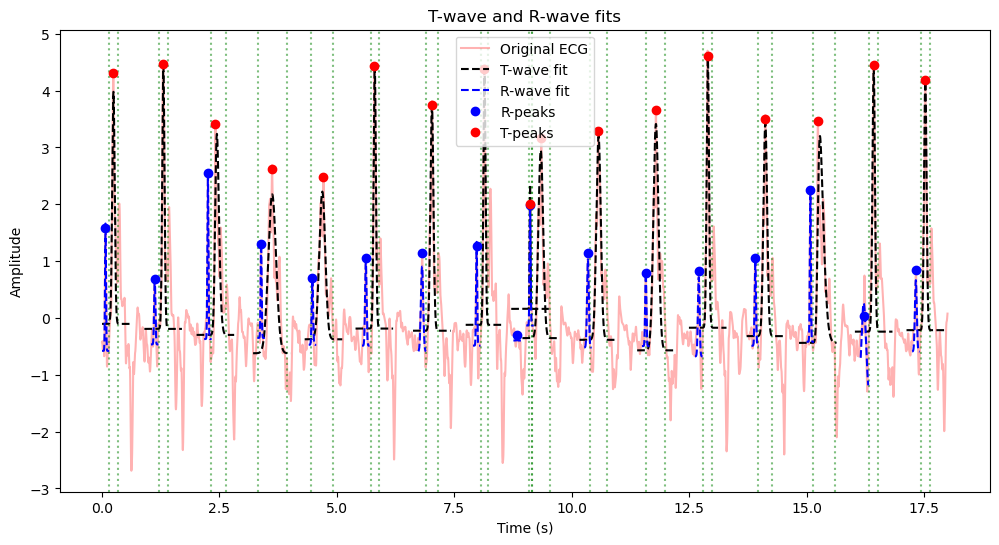

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from functools import partial
from scipy.stats import skewnorm
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# -------------------------------
# Wavelet-based T-wave detection
# -------------------------------
def detect_A6_peaks(signal, fs, wavelet='db4', level_max=6, height_factor=1.5):
    max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
    level = min(level_max, max_level)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    A6 = coeffs[0]
    A6_rec = pywt.waverec([A6] + [np.zeros_like(c) for c in coeffs[1:]], wavelet)[:len(signal)]
    peaks, _ = find_peaks(A6_rec, distance=int(0.2*fs),
                           height=np.mean(A6_rec) + height_factor*np.std(A6_rec))
    return peaks, A6_rec

# -------------------------------
# Skewed Gaussian for T-wave fits
# -------------------------------
def skewed_gaussian_peak_scaled(x, mu, sigma, alpha, baseline, height):
    pdf_vals = skewnorm.pdf(x, alpha, loc=mu, scale=sigma)
    return baseline + height * pdf_vals / np.max(pdf_vals)

def skewed_gaussian_width_baseline(popt, threshold_fraction=1e-3):
    mu, sigma, alpha, baseline = popt
    x_dense = np.linspace(mu - 10*sigma, mu + 10*sigma, 10000)
    y_dense = skewed_gaussian_peak_scaled(x_dense, *popt, height=1)
    threshold = baseline + threshold_fraction
    indices = np.where(y_dense > threshold)[0]
    if len(indices) == 0:
        return 0, mu, mu
    left_x = x_dense[indices[0]]
    right_x = x_dense[indices[-1]]
    return right_x - left_x, left_x, right_x

# -------------------------------
# Detect R-peaks in a window left of each T-wave
# -------------------------------
def detect_R_peaks_window(signal, peaks_A6, fs, lookback_ms=300, exclude_ms=150):
    lookback_samples = int(lookback_ms/1000*fs)
    exclude_samples = int(exclude_ms/1000*fs)  # Exclude region near T-wave
    R_peaks = []
    R_fits = []
    
    for t in peaks_A6:
        start = max(0, t - lookback_samples)
        end = max(0, t - exclude_samples)  # Stop before getting too close to T-wave
        
        if end <= start:
            # Fallback if window is invalid
            R_peaks.append(t - int(0.2*fs))
            R_fits.append((np.array([t - int(0.2*fs)]), np.array([signal[t - int(0.2*fs)]])))
            continue
            
        segment = signal[start:end]
        
        # Find the actual R-peak (maximum in the window, which should now be the R-wave)
        local_peak_idx = np.argmax(segment)
        peak_position = start + local_peak_idx
        
        # Create a smaller window around the detected peak for fitting
        fit_window = int(0.08 * fs)  # ~80ms window around R-peak
        fit_start = max(0, peak_position - fit_window)
        fit_end = min(len(signal), peak_position + fit_window)
        
        x = np.arange(fit_start, fit_end)
        y = signal[fit_start:fit_end]
        
        # Better initial guesses
        baseline = np.percentile(y, 10)  # Use lower percentile for baseline
        height = np.max(y) - baseline
        mu_guess = peak_position
        sigma_guess = 0.015 * fs  # Narrower initial guess
        
        try:
            def gaussian(x, mu, sigma, baseline, height):
                return baseline + height * np.exp(-(x-mu)**2/(2*sigma**2))
            
            # Add bounds to keep fit reasonable
            bounds = ([fit_start, 0.005*fs, baseline-0.5, 0],
                     [fit_end, 0.05*fs, baseline+0.5, height*2])
            
            popt, _ = curve_fit(gaussian, x, y, 
                               p0=[mu_guess, sigma_guess, baseline, height],
                               bounds=bounds,
                               maxfev=5000)
            
            mu_fit = popt[0]
            R_peaks.append(int(mu_fit))
            R_fits.append((x, gaussian(x, *popt)))
        except Exception as e:
            # Fallback to simple peak detection
            R_peaks.append(peak_position)
            R_fits.append((x, y))
    
    return np.array(R_peaks), R_fits

# -------------------------------
# Plot T-wave and R-wave fits
# -------------------------------
def plot_Twave_Rwave(signal, A6_rec, peaks_A6, fs, R_peaks, R_fits, title=""):
    plt.figure(figsize=(12,6))
    fit_window_samples = int(0.4*fs)

    # Plot original ECG
    plt.plot(np.arange(len(signal))/fs, signal, color='red', alpha=0.3, label="Original ECG")

    # Plot T-wave fits
    for t in peaks_A6:
        start = max(0, t - fit_window_samples)
        end = min(len(A6_rec), t + fit_window_samples)
        x = np.arange(start, end)
        y = A6_rec[start:end]

        baseline = np.median(y)
        height = signal[t] - baseline  # Use actual signal peak amplitude, not A6_rec
        
        # Fix mu to the detected peak position, only fit sigma, alpha, and baseline
        def fixed_peak_skewed_gaussian(x, sigma, alpha, baseline):
            return skewed_gaussian_peak_scaled(x, mu=t, sigma=sigma, alpha=alpha, 
                                               baseline=baseline, height=height)
        
        p0 = [0.05*fs, 0, baseline]

        try:
            popt, _ = curve_fit(fixed_peak_skewed_gaussian, x, y, p0=p0)
            y_fit = fixed_peak_skewed_gaussian(x, *popt)
            # Reconstruct full popt for width calculation
            full_popt = [t, popt[0], popt[1], popt[2]]
            _, left_x, right_x = skewed_gaussian_width_baseline(full_popt)
            # T-wave width lines
            plt.axvline(left_x/fs, color='green', linestyle=':', alpha=0.5)
            plt.axvline(right_x/fs, color='green', linestyle=':', alpha=0.5)
        except:
            y_fit = np.zeros_like(y)
        plt.plot(x/fs, y_fit, '--', color='black', label="T-wave fit" if t==peaks_A6[0] else "")

    # Plot R-wave fits and peak markers
    for i, (x_fit, y_fit) in enumerate(R_fits):
        plt.plot(x_fit/fs, y_fit, '--', color='blue', label='R-wave fit' if i==0 else "")
    plt.plot(R_peaks/fs, signal[R_peaks], 'bo', label='R-peaks')

    # T-peak markers
    plt.plot(peaks_A6/fs, signal[peaks_A6], 'ro', label='T-peaks')

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    plt.show()

# -------------------------------
# Main workflow
# -------------------------------
# Replace 'ecg_data' with your MNE Raw object
raw_ecg = ecg_data.copy().filter(1,30, picks='ECG')
signal = raw_ecg.get_data()[0][210000:300000]
time = raw_ecg.times[210000:300000]
fs = 1/np.mean(np.diff(time))

# Normalize
signal = (signal - np.mean(signal)) / np.std(signal)

# Detect T-wave peaks
peaks_A6, A6_rec = detect_A6_peaks(signal, fs)

# Detect R-peaks in window left of each T-wave
R_peaks, R_fits = detect_R_peaks_window(signal, peaks_A6, fs, lookback_ms=300)

# Plot everything
plot_Twave_Rwave(signal, A6_rec, peaks_A6, fs, R_peaks, R_fits, title="T-wave and R-wave fits")

# Fittings for Fuckheads!

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)

Detected 33 T-wave peaks
Detected 33 R-peaks (after minimum distance filtering)

Heart Rate Statistics:
  Mean: 52.1 bpm
  Std:  4.7 bpm
  Min:  41.9 bpm
  Max:  66.1 bpm

R-R Interval Statistics:
  Mean: 1161 ms
  Std:  105 ms


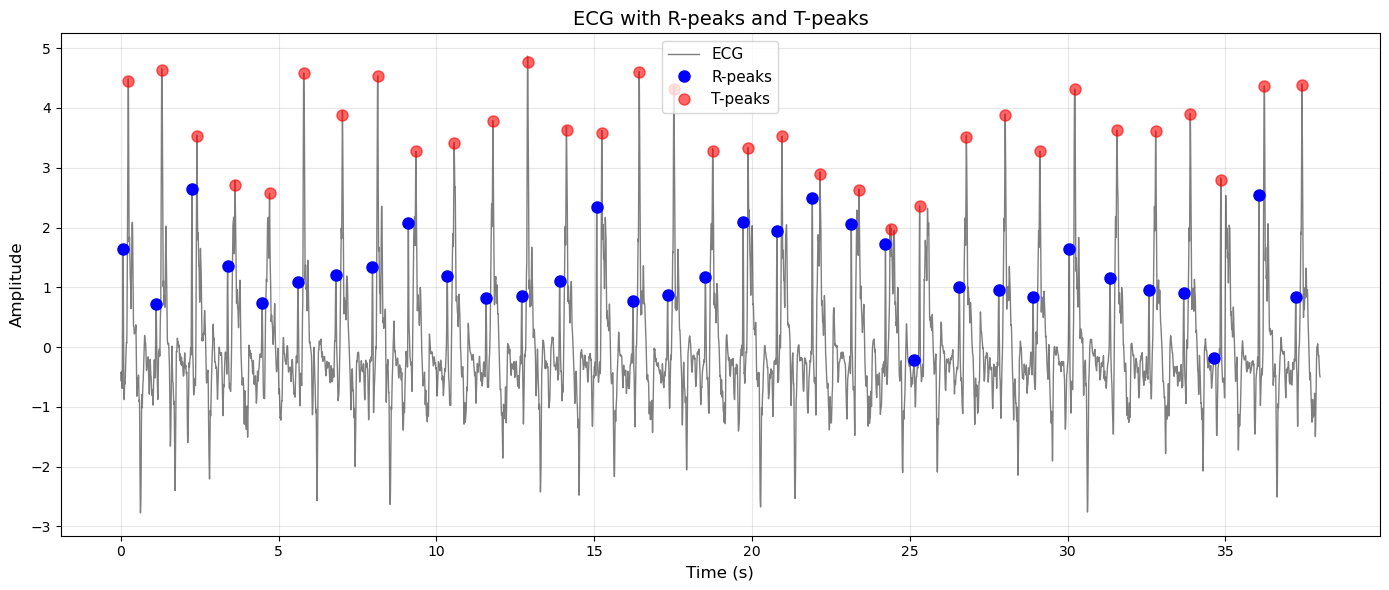

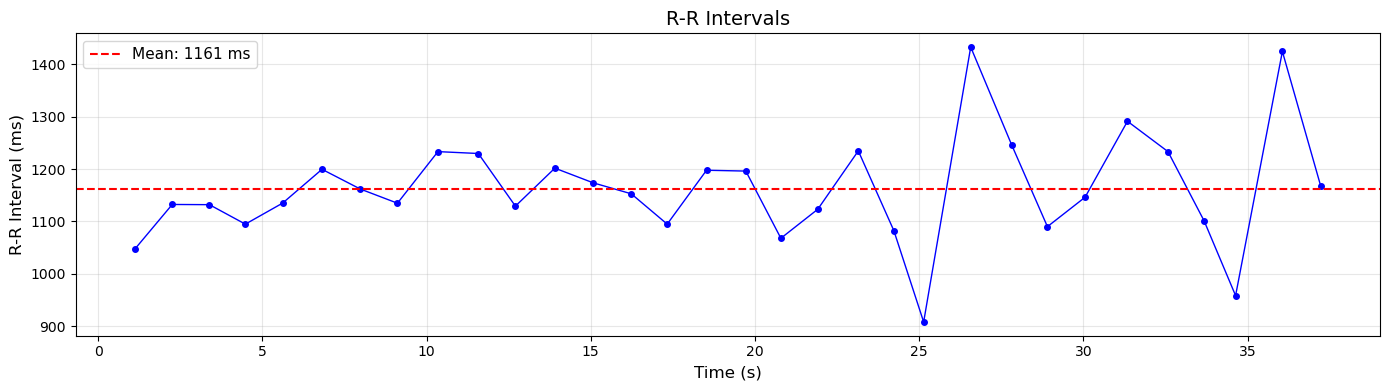


R-peak times (first 10): [ 0.0732  1.1208  2.2532  3.3852  4.48    5.615   6.8146  7.9766  9.1114
 10.3448]
R-peak sample indices (first 10): [  366  5604 11266 16926 22400 28075 34073 39883 45557 51724]


In [209]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks

# -------------------------------
# Wavelet-based T-wave detection
# -------------------------------
def detect_A6_peaks(signal, fs, wavelet='db4', level_max=6, height_factor=1.5, min_distance_ms=400):
    """
    Detect T-wave peaks using wavelet decomposition
    
    Parameters:
    -----------
    signal : array
        ECG signal
    fs : float
        Sampling frequency
    wavelet : str
        Wavelet type
    level_max : int
        Maximum decomposition level
    height_factor : float
        Peak height threshold factor
    min_distance_ms : float
        Minimum distance between T-peaks in milliseconds (default 400ms = max 150 bpm)
    
    Returns:
    --------
    peaks : array
        Detected T-wave peak positions
    """
    max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
    level = min(level_max, max_level)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    A6 = coeffs[0]
    A6_rec = pywt.waverec([A6] + [np.zeros_like(c) for c in coeffs[1:]], wavelet)[:len(signal)]
    
    # Convert minimum distance from ms to samples
    min_distance_samples = int(min_distance_ms / 1000 * fs)
    
    peaks, _ = find_peaks(A6_rec, 
                          distance=min_distance_samples,
                          height=np.mean(A6_rec) + height_factor*np.std(A6_rec))
    return peaks

# -------------------------------
# R-peak detection with minimum distance constraint
# -------------------------------
def detect_R_peaks_simple(signal, T_peaks, fs, lookback_ms=300, exclude_ms=150, min_rr_ms=300):
    """
    Detect R-peaks by searching backwards from each T-peak.
    Enforces minimum R-R interval constraint.
    
    Parameters:
    -----------
    signal : array
        ECG signal
    T_peaks : array
        Detected T-wave peak positions
    fs : float
        Sampling frequency
    lookback_ms : float
        How far back to search from T-peak (milliseconds)
    exclude_ms : float
        Exclusion zone before T-peak to avoid detecting T-wave (milliseconds)
    min_rr_ms : float
        Minimum allowed R-R interval (milliseconds). Default 300ms = 200 bpm max
    
    Returns:
    --------
    R_peaks : array
        Detected R-peak positions
    """
    lookback_samples = int(lookback_ms / 1000 * fs)
    exclude_samples = int(exclude_ms / 1000 * fs)
    min_rr_samples = int(min_rr_ms / 1000 * fs)
    
    R_peaks = []
    
    for t in T_peaks:
        # Define search window
        start = max(0, t - lookback_samples)
        end = max(0, t - exclude_samples)
        
        if end <= start:
            continue
        
        # Find maximum in this window
        segment = signal[start:end]
        R_peak_position = start + np.argmax(segment)
        
        # Check minimum distance constraint
        if len(R_peaks) == 0:
            # First peak, always accept
            R_peaks.append(R_peak_position)
        else:
            # Check if this peak is far enough from the last one
            if R_peak_position - R_peaks[-1] >= min_rr_samples:
                R_peaks.append(R_peak_position)
            else:
                # Too close! Keep whichever peak is higher
                if signal[R_peak_position] > signal[R_peaks[-1]]:
                    R_peaks[-1] = R_peak_position  # Replace with current (higher) peak
                # else: keep the previous peak
    
    return np.array(R_peaks)

# -------------------------------
# Visualization
# -------------------------------
def plot_peaks(signal, fs, T_peaks, R_peaks, title="ECG with R-peaks and T-peaks"):
    """Plot showing detected R and T peaks"""
    time = np.arange(len(signal)) / fs
    
    plt.figure(figsize=(14, 6))
    plt.plot(time, signal, 'k-', alpha=0.5, label='ECG', linewidth=1)
    plt.plot(R_peaks/fs, signal[R_peaks], 'bo', markersize=8, label='R-peaks', zorder=5)
    plt.plot(T_peaks/fs, signal[T_peaks], 'ro', markersize=8, label='T-peaks', alpha=0.6, zorder=4)
    
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_rr_intervals(R_peaks, fs, title="R-R Intervals"):
    """Plot R-R intervals over time"""
    RR_intervals = np.diff(R_peaks) / fs * 1000  # in milliseconds
    RR_times = R_peaks[1:] / fs  # time of each R-R interval
    
    plt.figure(figsize=(14, 4))
    plt.plot(RR_times, RR_intervals, 'b-o', markersize=4, linewidth=1)
    plt.axhline(np.mean(RR_intervals), color='r', linestyle='--', label=f'Mean: {np.mean(RR_intervals):.0f} ms')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('R-R Interval (ms)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Main workflow
# -------------------------------
# Load your data
raw_ecg = ecg_data.copy().filter(1, 30, picks='ECG')
signal = raw_ecg.get_data()[0][210000:400000]
time = raw_ecg.times[210000:400000]
fs = 1 / np.mean(np.diff(time))

# Normalize
signal = (signal - np.mean(signal)) / np.std(signal)

# Step 1: Detect T-wave peaks (as anchors)
# min_distance_ms: 400ms = max 150 bpm, 500ms = max 120 bpm, 300ms = max 200 bpm
T_peaks = detect_A6_peaks(signal, fs, min_distance_ms=400)
print(f"Detected {len(T_peaks)} T-wave peaks")

# Step 2: Detect R-peaks with minimum distance constraint
# min_rr_ms: 300ms = max 200 bpm, 400ms = max 150 bpm, 500ms = max 120 bpm
R_peaks = detect_R_peaks_simple(signal, T_peaks, fs, 
                                 lookback_ms=300, 
                                 exclude_ms=150, 
                                 min_rr_ms=400)  # Adjust based on expected HR
print(f"Detected {len(R_peaks)} R-peaks (after minimum distance filtering)")

# Step 3: Calculate heart rate statistics
RR_intervals = np.diff(R_peaks) / fs  # in seconds
heart_rate = 60 / RR_intervals  # beats per minute

print(f"\nHeart Rate Statistics:")
print(f"  Mean: {np.mean(heart_rate):.1f} bpm")
print(f"  Std:  {np.std(heart_rate):.1f} bpm")
print(f"  Min:  {np.min(heart_rate):.1f} bpm")
print(f"  Max:  {np.max(heart_rate):.1f} bpm")

print(f"\nR-R Interval Statistics:")
print(f"  Mean: {np.mean(RR_intervals)*1000:.0f} ms")
print(f"  Std:  {np.std(RR_intervals)*1000:.0f} ms")

# Plots
plot_peaks(signal, fs, T_peaks, R_peaks)
plot_rr_intervals(R_peaks, fs)

# Optional: Export R-peak times
R_peak_times = R_peaks / fs
print(f"\nR-peak times (first 10): {R_peak_times[:10]}")
print(f"R-peak sample indices (first 10): {R_peaks[:10]}")

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 16501 samples (3.300 s)



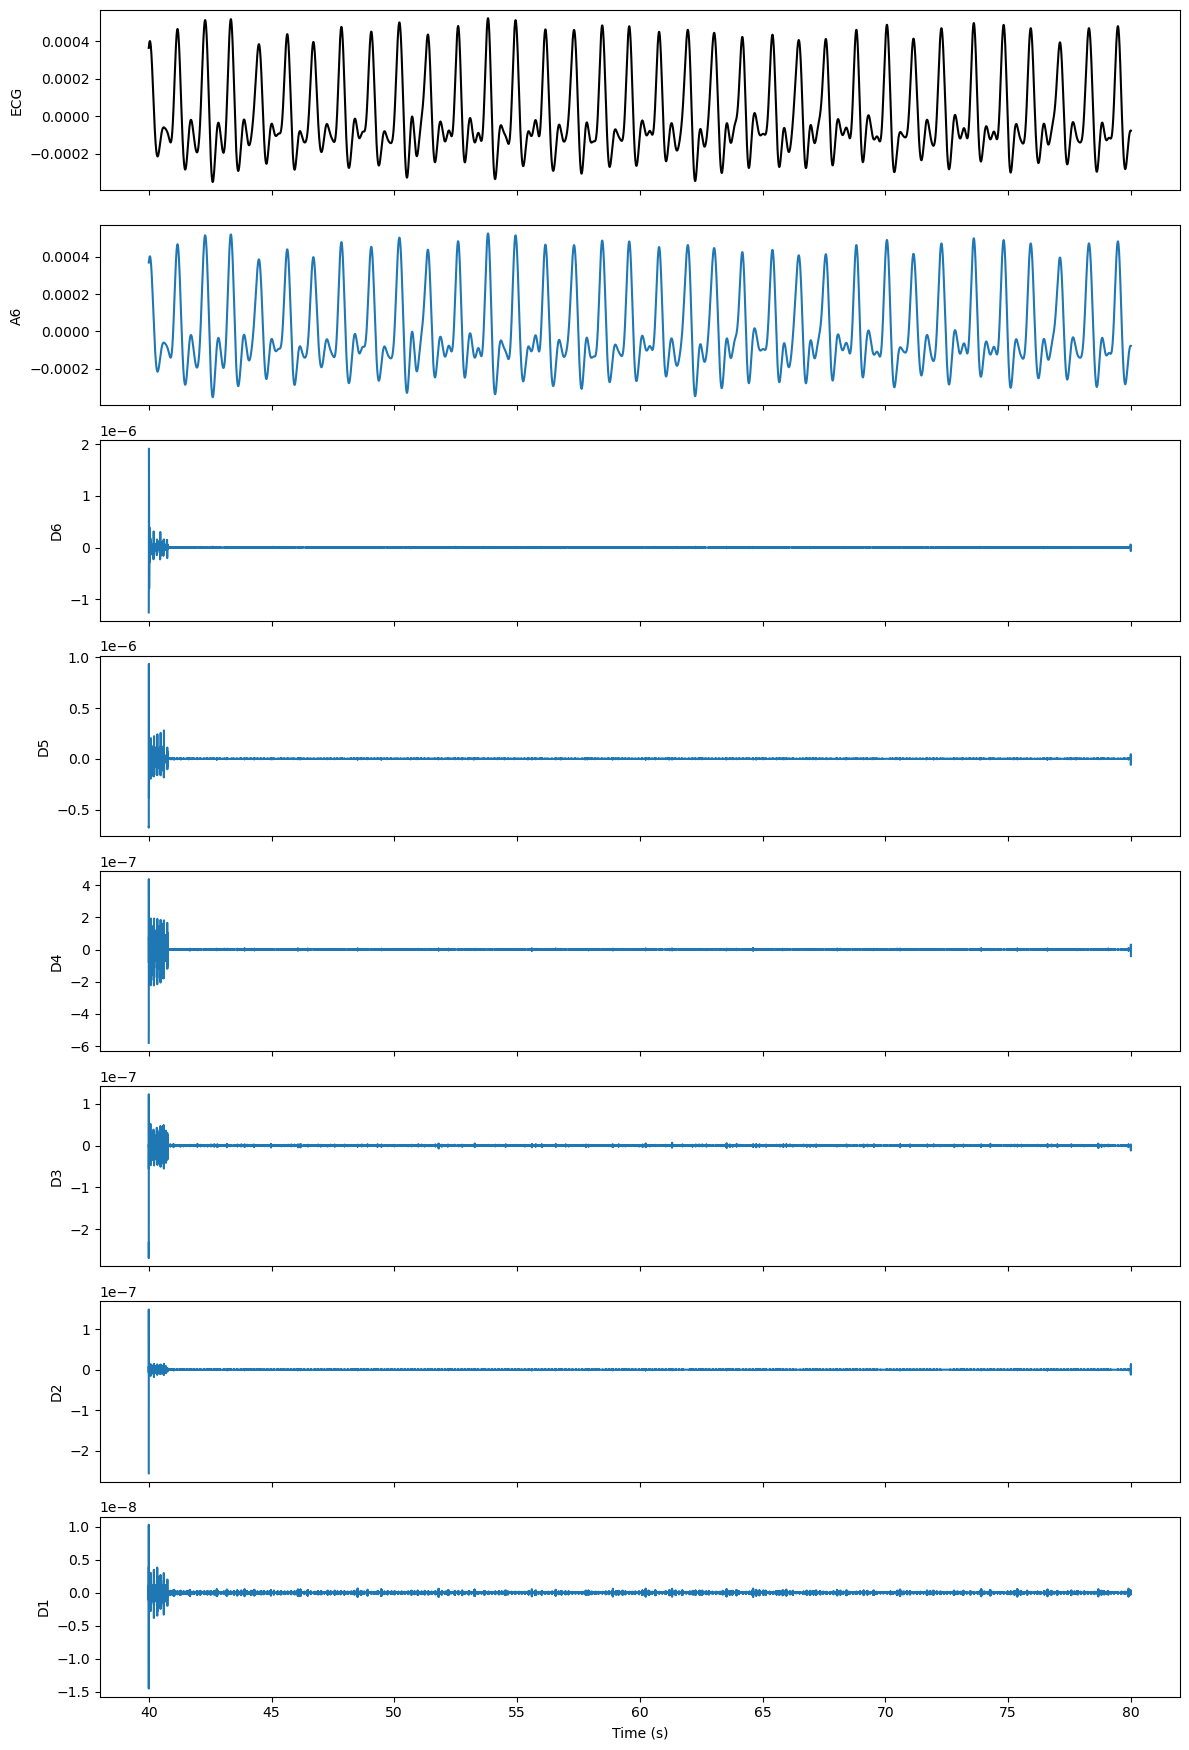

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# --- Preprocess ---
raw_ecg = ecg_data.copy().filter(1,2, picks ='ECG')

signal = raw_ecg.get_data()[0][200000:400000]
time = ecg_data.times[200000:400000]
dt = np.mean(np.diff(time))
fs = 1 / dt

# --- Wavelet decomposition ---
wavelet = 'db4'
max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
level = min(6, max_level)   # go deep, but not insane

coeffs = pywt.wavedec(signal, wavelet, level=level)
# coeffs = [cA_n, cD_n, cD_(n-1), ..., cD1]

labels = [f"A{level}"] + [f"D{l}" for l in range(level, 0, -1)]

# --- Helper to reconstruct individual components ---
def reconstruct_component(coeffs, wavelet, idx):
    coeffs_sel = []
    for i, c in enumerate(coeffs):
        if i == idx:
            coeffs_sel.append(c)
        else:
            coeffs_sel.append(np.zeros_like(c))
    return pywt.waverec(coeffs_sel, wavelet)[:len(signal)]

# --- Reconstruct all components ---
recon = [reconstruct_component(coeffs, wavelet, i)
         for i in range(len(coeffs))]

# --- Plot EVERYTHING ---
fig, axs = plt.subplots(len(recon) + 1, 1, sharex=True,
                        figsize=(12, 2.2 * (len(recon) + 1)))

axs[0].plot(time, signal, color='black')
axs[0].set_ylabel("ECG")

for i, (r, lab) in enumerate(zip(recon, labels), start=1):
    axs[i].plot(time, r)
    axs[i].set_ylabel(lab)

axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


# claude plz

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)

Peak 1: σ_L=219.4, σ_R=606.6, width=2507 samples
Peak 2: σ_L=202.2, σ_R=523.2, width=2202 samples
Peak 3: σ_L=149.8, σ_R=643.5, width=2408 samples
Peak 4: σ_L=371.2, σ_R=480.1, width=2584 samples
Peak 5: σ_L=464.9, σ_R=385.6, width=2583 samples
Peak 6: σ_L=170.8, σ_R=492.6, width=2014 samples
Peak 7: σ_L=240.8, σ_R=477.0, width=2179 sa

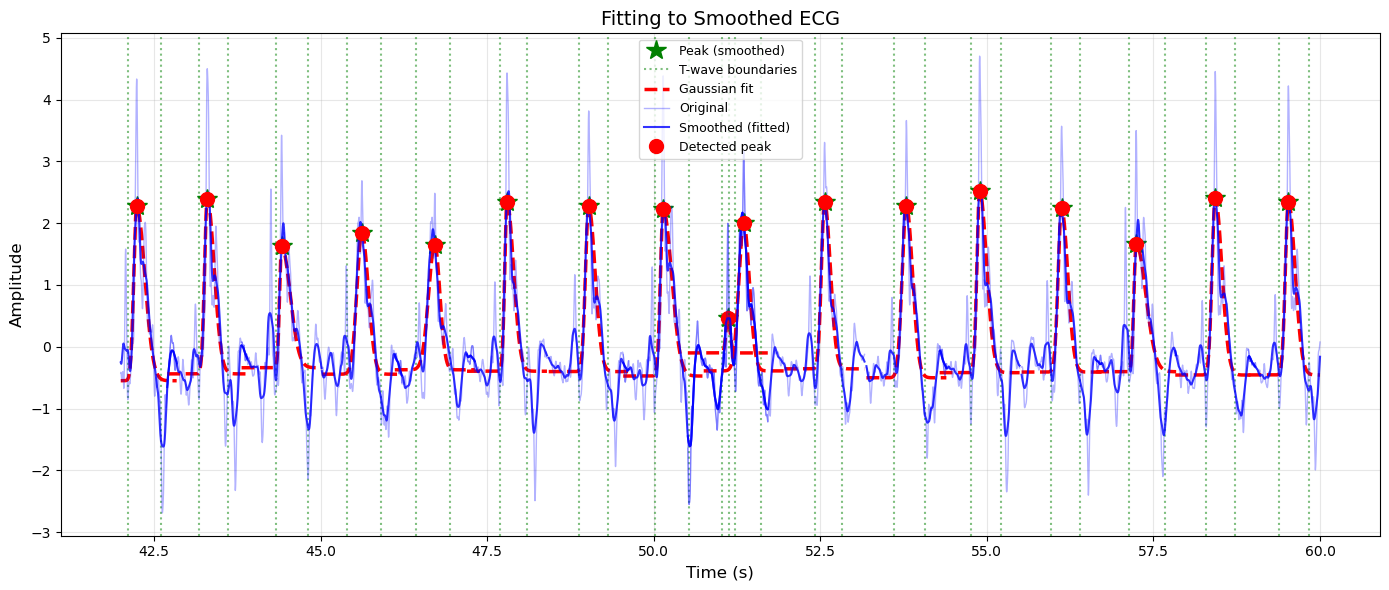

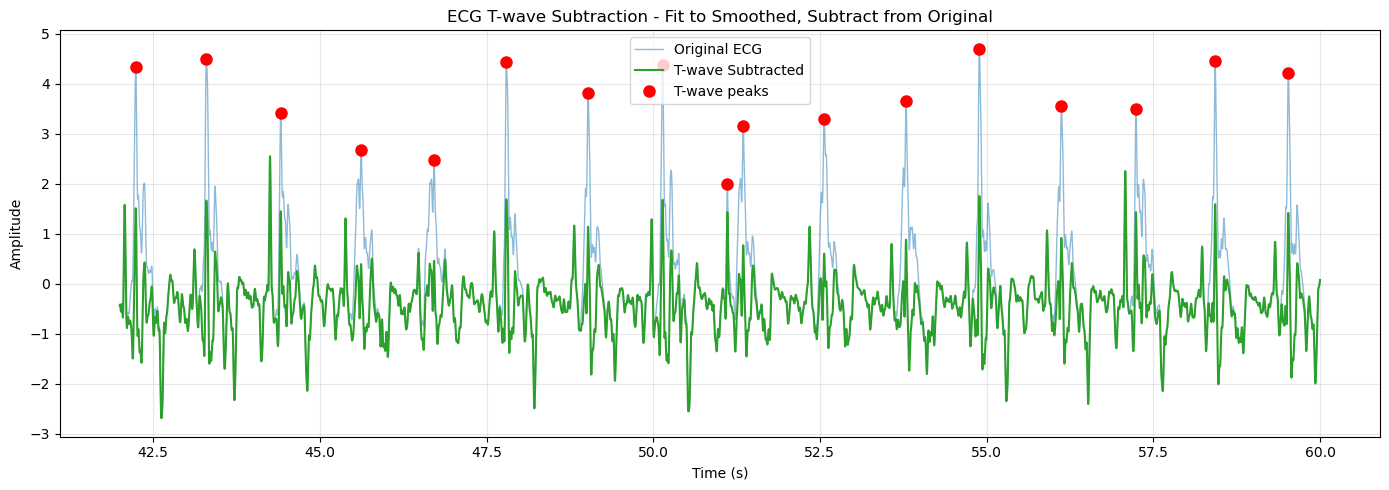

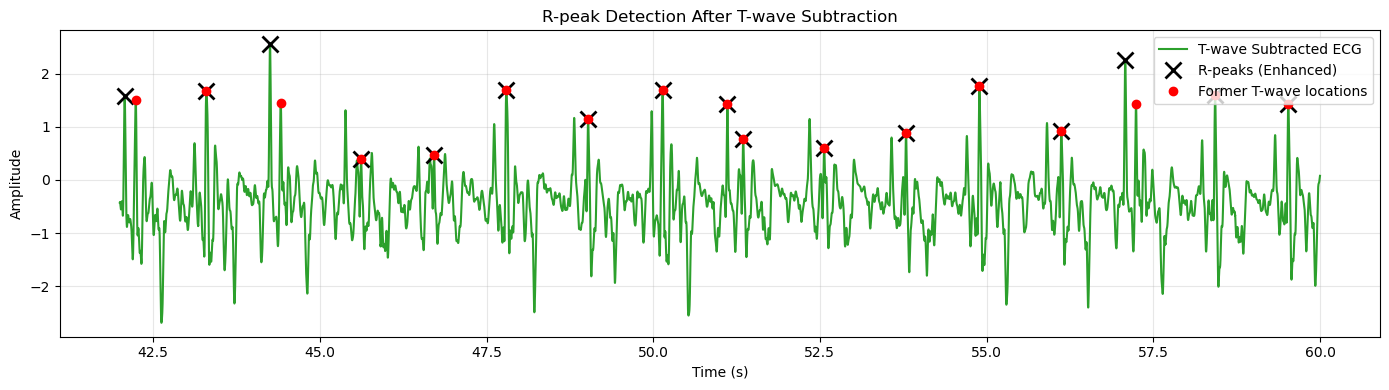


T-waves detected: 17
R-peaks detected: 17
R-peak amplitude - Original: 3.396, Enhanced: 1.341
Enhancement factor: 0.39x


In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
from functools import partial

# --- Wavelet-based T-wave detection ---
def detect_A6_peaks(signal, fs, wavelet='db4', level_max=6, height_factor=1.5, refine_window_ms=100):
    max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
    level = min(level_max, max_level)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    A6 = coeffs[0]
    A6_rec = pywt.waverec([A6] + [np.zeros_like(c) for c in coeffs[1:]], wavelet)[:len(signal)]

    # Find approximate peaks in A6
    peaks_A6, _ = find_peaks(A6_rec, distance=int(0.2*fs),
                           height=np.mean(A6_rec) + height_factor*np.std(A6_rec))
    
    # Refine peaks to find actual T-wave peak in original signal
    refine_window = int(refine_window_ms / 1000 * fs)
    peaks_refined = []
    
    for peak_A6 in peaks_A6:
        # Search in original signal around the A6 peak location
        search_start = max(0, peak_A6 - refine_window)
        search_end = min(len(signal), peak_A6 + refine_window)
        search_region = signal[search_start:search_end]
        
        # Find the actual maximum in the original signal
        local_max_idx = np.argmax(search_region)
        refined_peak = search_start + local_max_idx
        peaks_refined.append(refined_peak)
    
    return np.array(peaks_refined), A6_rec

# --- Asymmetric Gaussian with FIXED amplitude at peak ---
def asymmetric_gaussian_fixed_peak(x, mu, sigma_left, sigma_right, baseline, peak_value):
    """
    Asymmetric Gaussian where the peak HEIGHT is fixed to match the actual signal
    We only fit the widths and baseline
    """
    amplitude = peak_value - baseline
    result = np.zeros_like(x, dtype=float)
    left_mask = x <= mu
    right_mask = x > mu
    
    # Left side
    if np.any(left_mask):
        result[left_mask] = baseline + amplitude * np.exp(-0.5 * ((x[left_mask] - mu) / sigma_left) ** 2)
    
    # Right side
    if np.any(right_mask):
        result[right_mask] = baseline + amplitude * np.exp(-0.5 * ((x[right_mask] - mu) / sigma_right) ** 2)
    
    return result

# --- Compute width at near-baseline ---
def compute_twave_boundaries(sigma_left, sigma_right, mu, baseline, peak_value, threshold_fraction=0.01):
    """
    Find T-wave boundaries where fitted curve returns to near baseline
    """
    amplitude = peak_value - baseline
    threshold = baseline + threshold_fraction * abs(amplitude)
    
    # Search left until we hit baseline
    x_left = mu
    for i in range(1, 10000):
        x = mu - i
        val = baseline + amplitude * np.exp(-0.5 * (i / sigma_left) ** 2)
        if val <= threshold:
            x_left = x
            break
    
    # Search right until we hit baseline
    x_right = mu
    for i in range(1, 10000):
        x = mu + i
        val = baseline + amplitude * np.exp(-0.5 * (i / sigma_right) ** 2)
        if val <= threshold:
            x_right = x
            break
    
    return x_left, x_right, mu

# --- Plot T-wave fits with SMOOTHING ---
def plot_Twave_fits(signal_to_plot, A6_rec, peaks_A6, time, fs, fit_window_ms=600, smooth_window_ms=1000, title=""):
    fit_window_samples = int(fit_window_ms / 1000 * fs)
    smooth_window = int(smooth_window_ms / 1000 * fs)
    
    # SMOOTH the signal with rolling average to get clean T-wave shape!
    signal_smooth = np.convolve(signal_to_plot, np.ones(smooth_window)/smooth_window, mode='same')
    
    plt.figure(figsize=(14,6))

    for idx, t in enumerate(peaks_A6):
        start = max(0, t - fit_window_samples)
        end = min(len(signal_to_plot), t + fit_window_samples)
        x_local = np.arange(start, end)
        
        # Fit to the SMOOTHED signal (cleaner T-wave)
        y = signal_smooth[start:end]

        # Estimate baseline
        edge_samples = max(5, int(0.2 * len(y)))
        baseline_guess = np.mean(np.concatenate([y[:edge_samples], y[-edge_samples:]]))
        
        # Peak value from SMOOTHED signal
        peak_value = signal_smooth[t]
        
        sigma_guess = 0.05 * fs
        
        def fit_func(x, sigma_left, sigma_right, baseline):
            return asymmetric_gaussian_fixed_peak(x, t, sigma_left, sigma_right, baseline, peak_value)
        
        p0 = [sigma_guess, sigma_guess, baseline_guess]

        try:
            popt, pcov = curve_fit(fit_func, x_local, y, p0=p0, maxfev=20000)
            sigma_left, sigma_right, baseline_fit = popt
            
            y_fit = fit_func(x_local, *popt)
            left_x, right_x, _ = compute_twave_boundaries(sigma_left, sigma_right, t, baseline_fit, peak_value, threshold_fraction=0.01)
            
            print(f"Peak {idx+1}: σ_L={sigma_left:.1f}, σ_R={sigma_right:.1f}, width={int(right_x-left_x)} samples")
            
            plt.plot(time[t], peak_value, 'g*', markersize=15, label='Peak (smoothed)' if idx==0 else '')
            plt.axvline(time[int(left_x)], color='green', linestyle=':', alpha=0.5, label='T-wave boundaries' if idx==0 else '')
            plt.axvline(time[int(right_x)], color='green', linestyle=':', alpha=0.5)
            plt.plot(time[start:end], y_fit, 'r--', linewidth=2.5, label="Gaussian fit" if idx==0 else "")
            
        except Exception as e:
            print(f"Fit failed at peak {t}: {e}")
            continue

        # Show original (faint) and smoothed (solid)
        plt.plot(time[start:end], signal_to_plot[start:end], 'b-', alpha=0.3, linewidth=1, label="Original" if idx==0 else "")
        plt.plot(time[start:end], signal_smooth[start:end], 'b-', alpha=0.8, linewidth=1.5, label="Smoothed (fitted)" if idx==0 else "")
        plt.plot(time[t], signal_smooth[t], 'ro', markersize=10, label='Detected peak' if idx==0 else '')

    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=9, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Subtract T-waves using smoothed signal for fitting ---
def subtract_Twaves(signal, A6_rec, peaks_A6, fs, fit_window_ms=600, smooth_window_ms=100):
    """
    Fit to SMOOTHED signal, then subtract from ORIGINAL signal
    """
    ecg_enhanced = signal.copy()
    fit_window_samples = int(fit_window_ms / 1000 * fs)
    smooth_window = int(smooth_window_ms / 1000 * fs)
    
    # Smooth the signal
    signal_smooth = np.convolve(signal, np.ones(smooth_window)/smooth_window, mode='same')

    for t in peaks_A6:
        start = max(0, t - fit_window_samples)
        end = min(len(signal), t + fit_window_samples)
        x_local = np.arange(start, end)
        
        # Fit to smoothed
        y = signal_smooth[start:end]
        edge_samples = max(5, int(0.2 * len(y)))
        baseline_guess = np.mean(np.concatenate([y[:edge_samples], y[-edge_samples:]]))
        peak_value = signal_smooth[t]
        
        def fit_func(x, sigma_left, sigma_right, baseline):
            return asymmetric_gaussian_fixed_peak(x, t, sigma_left, sigma_right, baseline, peak_value)
        
        sigma_guess = 0.05 * fs
        p0 = [sigma_guess, sigma_guess, baseline_guess]

        try:
            popt, _ = curve_fit(fit_func, x_local, y, p0=p0, maxfev=20000)
            sigma_left, sigma_right, baseline_fit = popt
            
            left_x, right_x, _ = compute_twave_boundaries(sigma_left, sigma_right, t, baseline_fit, peak_value, threshold_fraction=0.01)
            left = max(0, int(left_x))
            right = min(len(signal), int(right_x))

            # Generate fitted T-wave and SUBTRACT from ORIGINAL signal
            x_subtract = np.arange(left, right)
            y_fitted = asymmetric_gaussian_fixed_peak(x_subtract, t, sigma_left, sigma_right, baseline_fit, peak_value)
            twave_component = y_fitted - baseline_fit
            ecg_enhanced[left:right] -= twave_component

        except Exception as e:
            print(f"Failed to fit T-wave at index {t}: {e}")
            pass

    return ecg_enhanced

# --- MAIN WORKFLOW ---
raw_ecg = ecg_data.copy().filter(1,30, picks='ECG')
signal = raw_ecg.get_data()[0][210000:300000]
time = raw_ecg.times[210000:300000]
dt = np.mean(np.diff(time))
fs = 1 / dt

# Normalize ECG
signal = (signal - np.mean(signal)) / np.std(signal)

# Detect T-wave peaks
peaks_A6, A6_rec = detect_A6_peaks(signal, fs)

# Plot fits (fitting to SMOOTHED signal)
plot_Twave_fits(signal, A6_rec, peaks_A6, time, fs, fit_window_ms=600, smooth_window_ms=100, 
                title="Fitting to Smoothed ECG")

# SUBTRACT T-waves
ecg_enhanced = subtract_Twaves(signal, A6_rec, peaks_A6, fs, fit_window_ms=600, smooth_window_ms=100)

# --- Plot comparison ---
plt.figure(figsize=(14,5))
plt.plot(time, signal, label='Original ECG', alpha=0.5, linewidth=1)
plt.plot(time, ecg_enhanced, label='T-wave Subtracted', color='tab:green', linewidth=1.5)
plt.plot(time[peaks_A6], signal[peaks_A6], 'ro', markersize=8, label='T-wave peaks')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG T-wave Subtraction - Fit to Smoothed, Subtract from Original")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Detect R-peaks ---
lookback_ms = 200
lookback_samples = int(lookback_ms / 1000 * fs)
R_peaks = np.array([t - lookback_samples + np.argmax(ecg_enhanced[max(0, t - lookback_samples):t])
                    for t in peaks_A6 if t >= lookback_samples])

# --- Plot with R-peaks ---
plt.figure(figsize=(14,4))
plt.plot(time, ecg_enhanced, label='T-wave Subtracted ECG', linewidth=1.5, color='tab:green')
plt.plot(time[R_peaks], ecg_enhanced[R_peaks], 'kx', markersize=12, markeredgewidth=2, label='R-peaks (Enhanced)')
plt.plot(time[peaks_A6], ecg_enhanced[peaks_A6], 'ro', markersize=6, label='Former T-wave locations')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("R-peak Detection After T-wave Subtraction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stats
print(f"\nT-waves detected: {len(peaks_A6)}")
print(f"R-peaks detected: {len(R_peaks)}")
if len(R_peaks) > 0:
    r_amp_orig = np.mean(signal[R_peaks])
    r_amp_enh = np.mean(ecg_enhanced[R_peaks])
    print(f"R-peak amplitude - Original: {r_amp_orig:.3f}, Enhanced: {r_amp_enh:.3f}")
    print(f"Enhancement factor: {r_amp_enh/r_amp_orig:.2f}x")

### Madness lies here

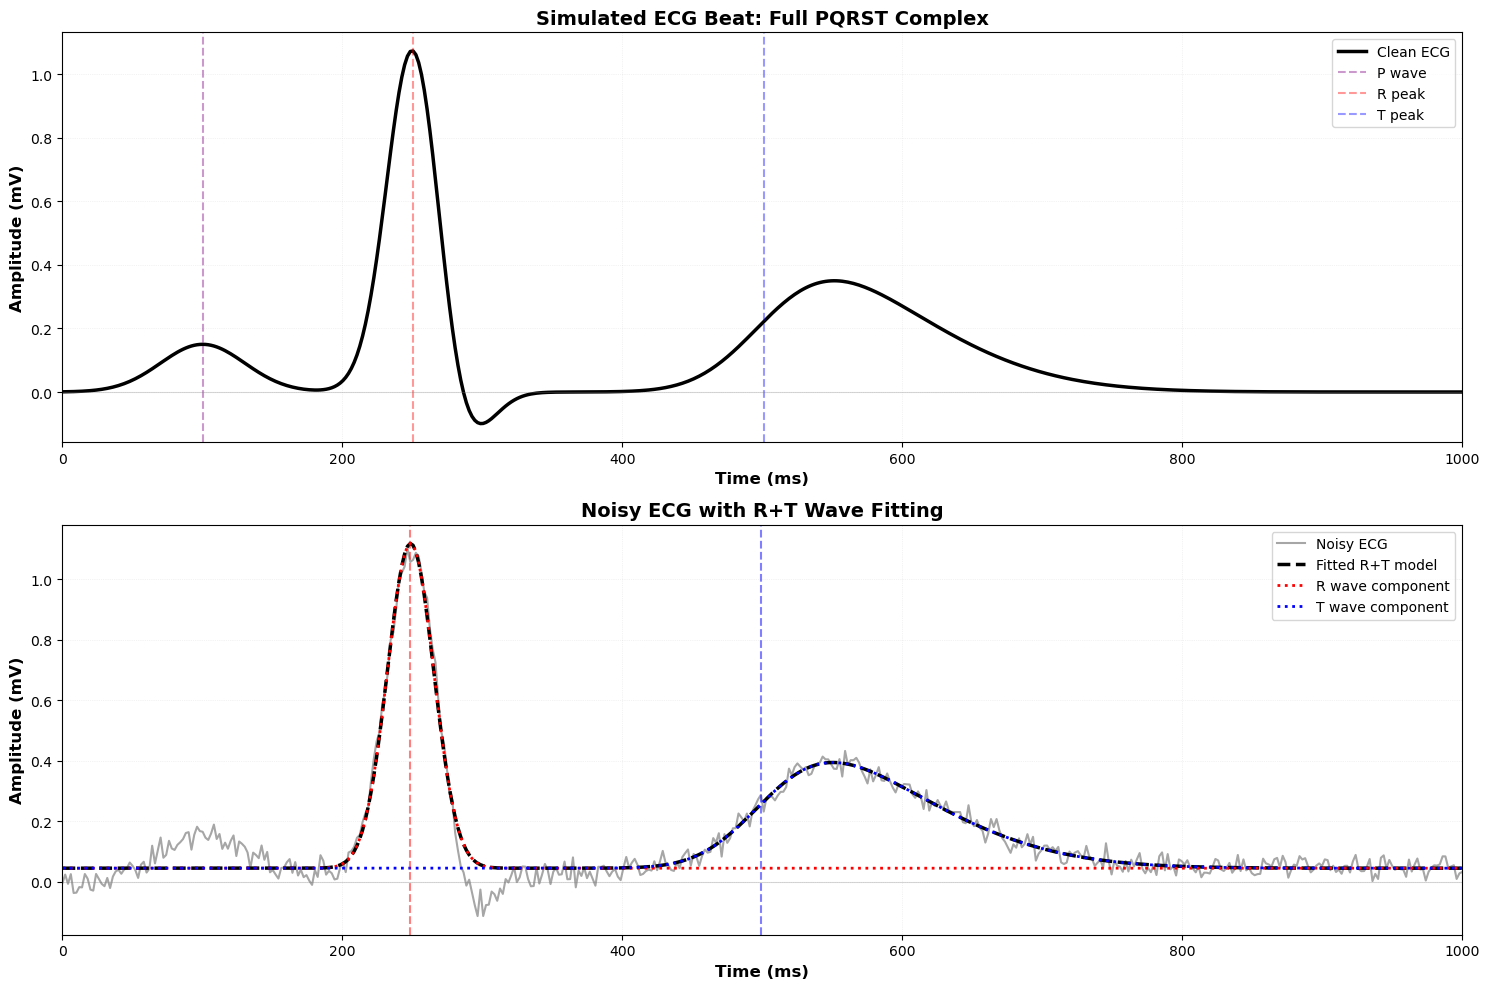

ECG ANALYSIS RESULTS
R peak position:     248.2 ms
R peak amplitude:    1.074 mV
R wave width:        16.5 ms

T peak position:     499.2 ms
T peak amplitude:    0.349 mV
T wave width:        102.3 ms
T wave skewness:     2.72

R-T interval:        250.9 ms
Baseline:            0.044 mV

Simulated heart rate: 60 bpm


In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import skewnorm

# --- Realistic ECG beat model: P + QRS complex + T wave ---
def ecg_beat_model(x, 
                   p_pos, p_width, p_height,
                   q_pos, q_width, q_depth,
                   r_pos, r_width, r_height,
                   s_pos, s_width, s_depth,
                   t_pos, t_width, t_skew, t_height,
                   baseline):
    
    # P wave: small rounded bump
    p_wave = p_height * np.exp(-((x - p_pos) ** 2) / (2 * p_width ** 2))
    
    # Q wave: small negative deflection
    q_wave = -q_depth * np.exp(-((x - q_pos) ** 2) / (2 * q_width ** 2))
    
    # R wave: tall sharp peak
    r_wave = r_height * np.exp(-((x - r_pos) ** 2) / (2 * r_width ** 2))
    
    # S wave: negative deflection after R
    s_wave = -s_depth * np.exp(-((x - s_pos) ** 2) / (2 * s_width ** 2))
    
    # T wave: broader, slightly skewed positive wave
    t_wave = skewnorm.pdf(x, t_skew, loc=t_pos, scale=t_width)
    t_wave = t_height * t_wave / np.max(t_wave)
    
    return baseline + p_wave + q_wave + r_wave + s_wave + t_wave

# --- Simplified R + T model for easier fitting ---
def r_t_wave_model(x, r_pos, r_width, r_height, t_pos, t_width, t_skew, t_height, baseline):
    # R wave: narrow Gaussian
    r_wave = r_height * np.exp(-((x - r_pos) ** 2) / (2 * r_width ** 2))
    # T wave: skewed Gaussian
    t_wave = skewnorm.pdf(x, t_skew, loc=t_pos, scale=t_width)
    t_wave = t_height * t_wave / np.max(t_wave)
    return baseline + r_wave + t_wave

# --- SIMULATE REALISTIC ECG BEAT ---
fs = 500  # 500 Hz sampling (typical for ECG)
duration = 1.0  # 1 second beat
time = np.linspace(0, duration, int(fs * duration))
x = np.arange(len(time))

# Realistic timing (in samples at 500 Hz)
# P wave at ~0.1s, QRS at ~0.25s, T wave at ~0.5s
baseline = 0.0
p_pos, p_width, p_height = 50, 15, 0.15
q_pos, q_width, q_depth = 115, 8, 0.1
r_pos, r_width, r_height = 125, 10, 1.2
s_pos, s_width, s_depth = 140, 10, 0.25
t_pos, t_width, t_skew, t_height = 250, 50, 2.5, 0.35

# Generate clean ECG
ecg_clean = ecg_beat_model(x, 
                           p_pos, p_width, p_height,
                           q_pos, q_width, q_depth,
                           r_pos, r_width, r_height,
                           s_pos, s_width, s_depth,
                           t_pos, t_width, t_skew, t_height,
                           baseline)

# Add realistic noise
# 1. Baseline wander (low frequency)
baseline_wander = 0.05 * np.sin(2 * np.pi * 0.3 * time)
# 2. Muscle artifact (higher frequency)
muscle_noise = 0.02 * np.random.randn(len(x))
# 3. Powerline interference (50/60 Hz)
powerline = 0.01 * np.sin(2 * np.pi * 50 * time)

ecg_signal = ecg_clean + baseline_wander + muscle_noise + powerline

# --- FIT THE SIMPLIFIED R + T MODEL ---
# Find R peak
r_guess = np.argmax(ecg_signal)
# Find T peak (look after R peak)
t_search_start = r_guess + int(0.15 * fs)
t_search_end = min(r_guess + int(0.4 * fs), len(ecg_signal))
t_guess = t_search_start + np.argmax(ecg_signal[t_search_start:t_search_end])

baseline_guess = np.median(ecg_signal[:50])  # baseline from early part
r_height_guess = ecg_signal[r_guess] - baseline_guess
t_height_guess = ecg_signal[t_guess] - baseline_guess

# Initial parameters: [r_pos, r_width, r_height, t_pos, t_width, t_skew, t_height, baseline]
p0 = [r_guess, 10, r_height_guess, t_guess, 50, 2, t_height_guess, baseline_guess]

# Bounds
bounds = ([r_guess-30, 5, 0.5, t_guess-50, 20, -3, 0.1, -0.5],
          [r_guess+30, 25, 3.0, t_guess+50, 100, 8, 1.0, 0.5])

try:
    popt, pcov = curve_fit(r_t_wave_model, x, ecg_signal, p0=p0, bounds=bounds, maxfev=15000)
    fit_success = True
except:
    print("Fitting failed, using initial guesses")
    popt = p0
    fit_success = False

# --- GENERATE FITTED COMPONENTS ---
fitted_signal = r_t_wave_model(x, *popt)

# Separate R and T components
r_component = popt[7] + popt[2] * np.exp(-((x - popt[0]) ** 2) / (2 * popt[1] ** 2))
t_wave_pdf = skewnorm.pdf(x, popt[5], loc=popt[3], scale=popt[4])
t_component = popt[7] + popt[6] * t_wave_pdf / np.max(t_wave_pdf)

# --- PLOTTING ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Clean ECG with all components
ax1 = axes[0]
ax1.plot(time * 1000, ecg_clean, linewidth=2.5, color='black', label='Clean ECG')
ax1.axvline(time[p_pos] * 1000, color='purple', linestyle='--', alpha=0.4, linewidth=1.5, label='P wave')
ax1.axvline(time[r_pos] * 1000, color='red', linestyle='--', alpha=0.4, linewidth=1.5, label='R peak')
ax1.axvline(time[t_pos] * 1000, color='blue', linestyle='--', alpha=0.4, linewidth=1.5, label='T peak')
ax1.axhline(0, color='gray', linestyle='-', alpha=0.3, linewidth=0.8)
ax1.set_xlabel("Time (ms)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Amplitude (mV)", fontsize=12, fontweight='bold')
ax1.set_title("Simulated ECG Beat: Full PQRST Complex", fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(alpha=0.3, linestyle=':', linewidth=0.5)
ax1.set_xlim(0, 1000)

# Plot 2: Noisy signal with R+T fit
ax2 = axes[1]
ax2.plot(time * 1000, ecg_signal, alpha=0.7, linewidth=1.5, label='Noisy ECG', color='gray')
if fit_success:
    ax2.plot(time * 1000, fitted_signal, '--', linewidth=2.5, color='black', label='Fitted R+T model')
    ax2.plot(time * 1000, r_component, ':', linewidth=2, color='red', label='R wave component')
    ax2.plot(time * 1000, t_component, ':', linewidth=2, color='blue', label='T wave component')
    ax2.axvline(time[int(popt[0])] * 1000, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax2.axvline(time[int(popt[3])] * 1000, color='blue', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.axhline(0, color='gray', linestyle='-', alpha=0.3, linewidth=0.8)
ax2.set_xlabel("Time (ms)", fontsize=12, fontweight='bold')
ax2.set_ylabel("Amplitude (mV)", fontsize=12, fontweight='bold')
ax2.set_title("Noisy ECG with R+T Wave Fitting", fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(alpha=0.3, linestyle=':', linewidth=0.5)
ax2.set_xlim(0, 1000)

plt.tight_layout()
plt.show()

# --- PRINT DIAGNOSTICS ---
if fit_success:
    print("=" * 60)
    print("ECG ANALYSIS RESULTS")
    print("=" * 60)
    print(f"R peak position:     {popt[0]/fs*1000:.1f} ms")
    print(f"R peak amplitude:    {popt[2]:.3f} mV")
    print(f"R wave width:        {popt[1]/fs*1000:.1f} ms")
    print(f"\nT peak position:     {popt[3]/fs*1000:.1f} ms")
    print(f"T peak amplitude:    {popt[6]:.3f} mV")
    print(f"T wave width:        {popt[4]/fs*1000:.1f} ms")
    print(f"T wave skewness:     {popt[5]:.2f}")
    print(f"\nR-T interval:        {(popt[3]-popt[0])/fs*1000:.1f} ms")
    print(f"Baseline:            {popt[7]:.3f} mV")
    print("=" * 60)
    
    # Calculate heart rate from R-R interval (assuming this is one beat)
    beat_duration = duration  # seconds
    heart_rate = 60 / beat_duration
    print(f"\nSimulated heart rate: {heart_rate:.0f} bpm")
    print("=" * 60)

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)

Sampling frequency: 5000.0 Hz
Signal duration: 38.00 seconds
Signal range: [-7.49e-04, 1.32e-03]

Detected 35 R peaks
Beat 21 fit failed: Each lower bound must be strictly less than each upper bound.

Successfully fitted 34 beats


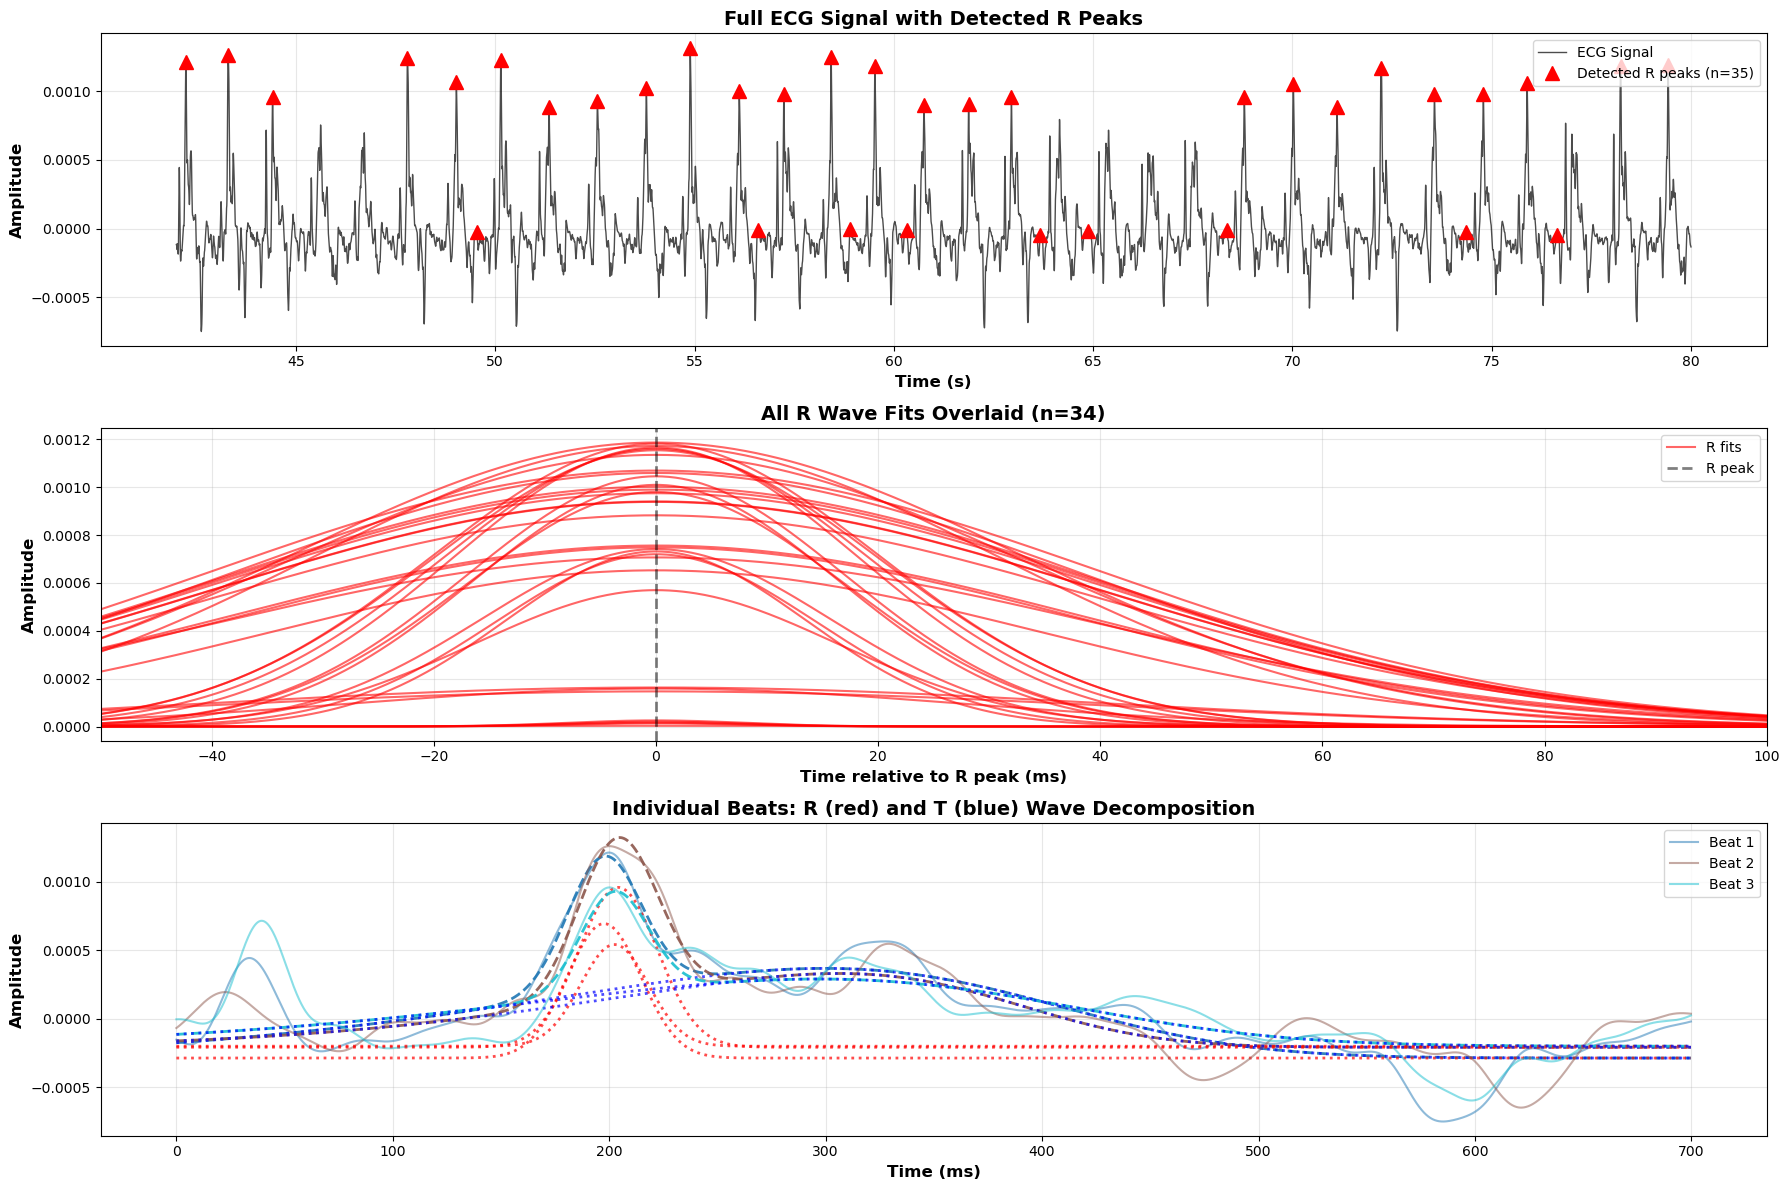

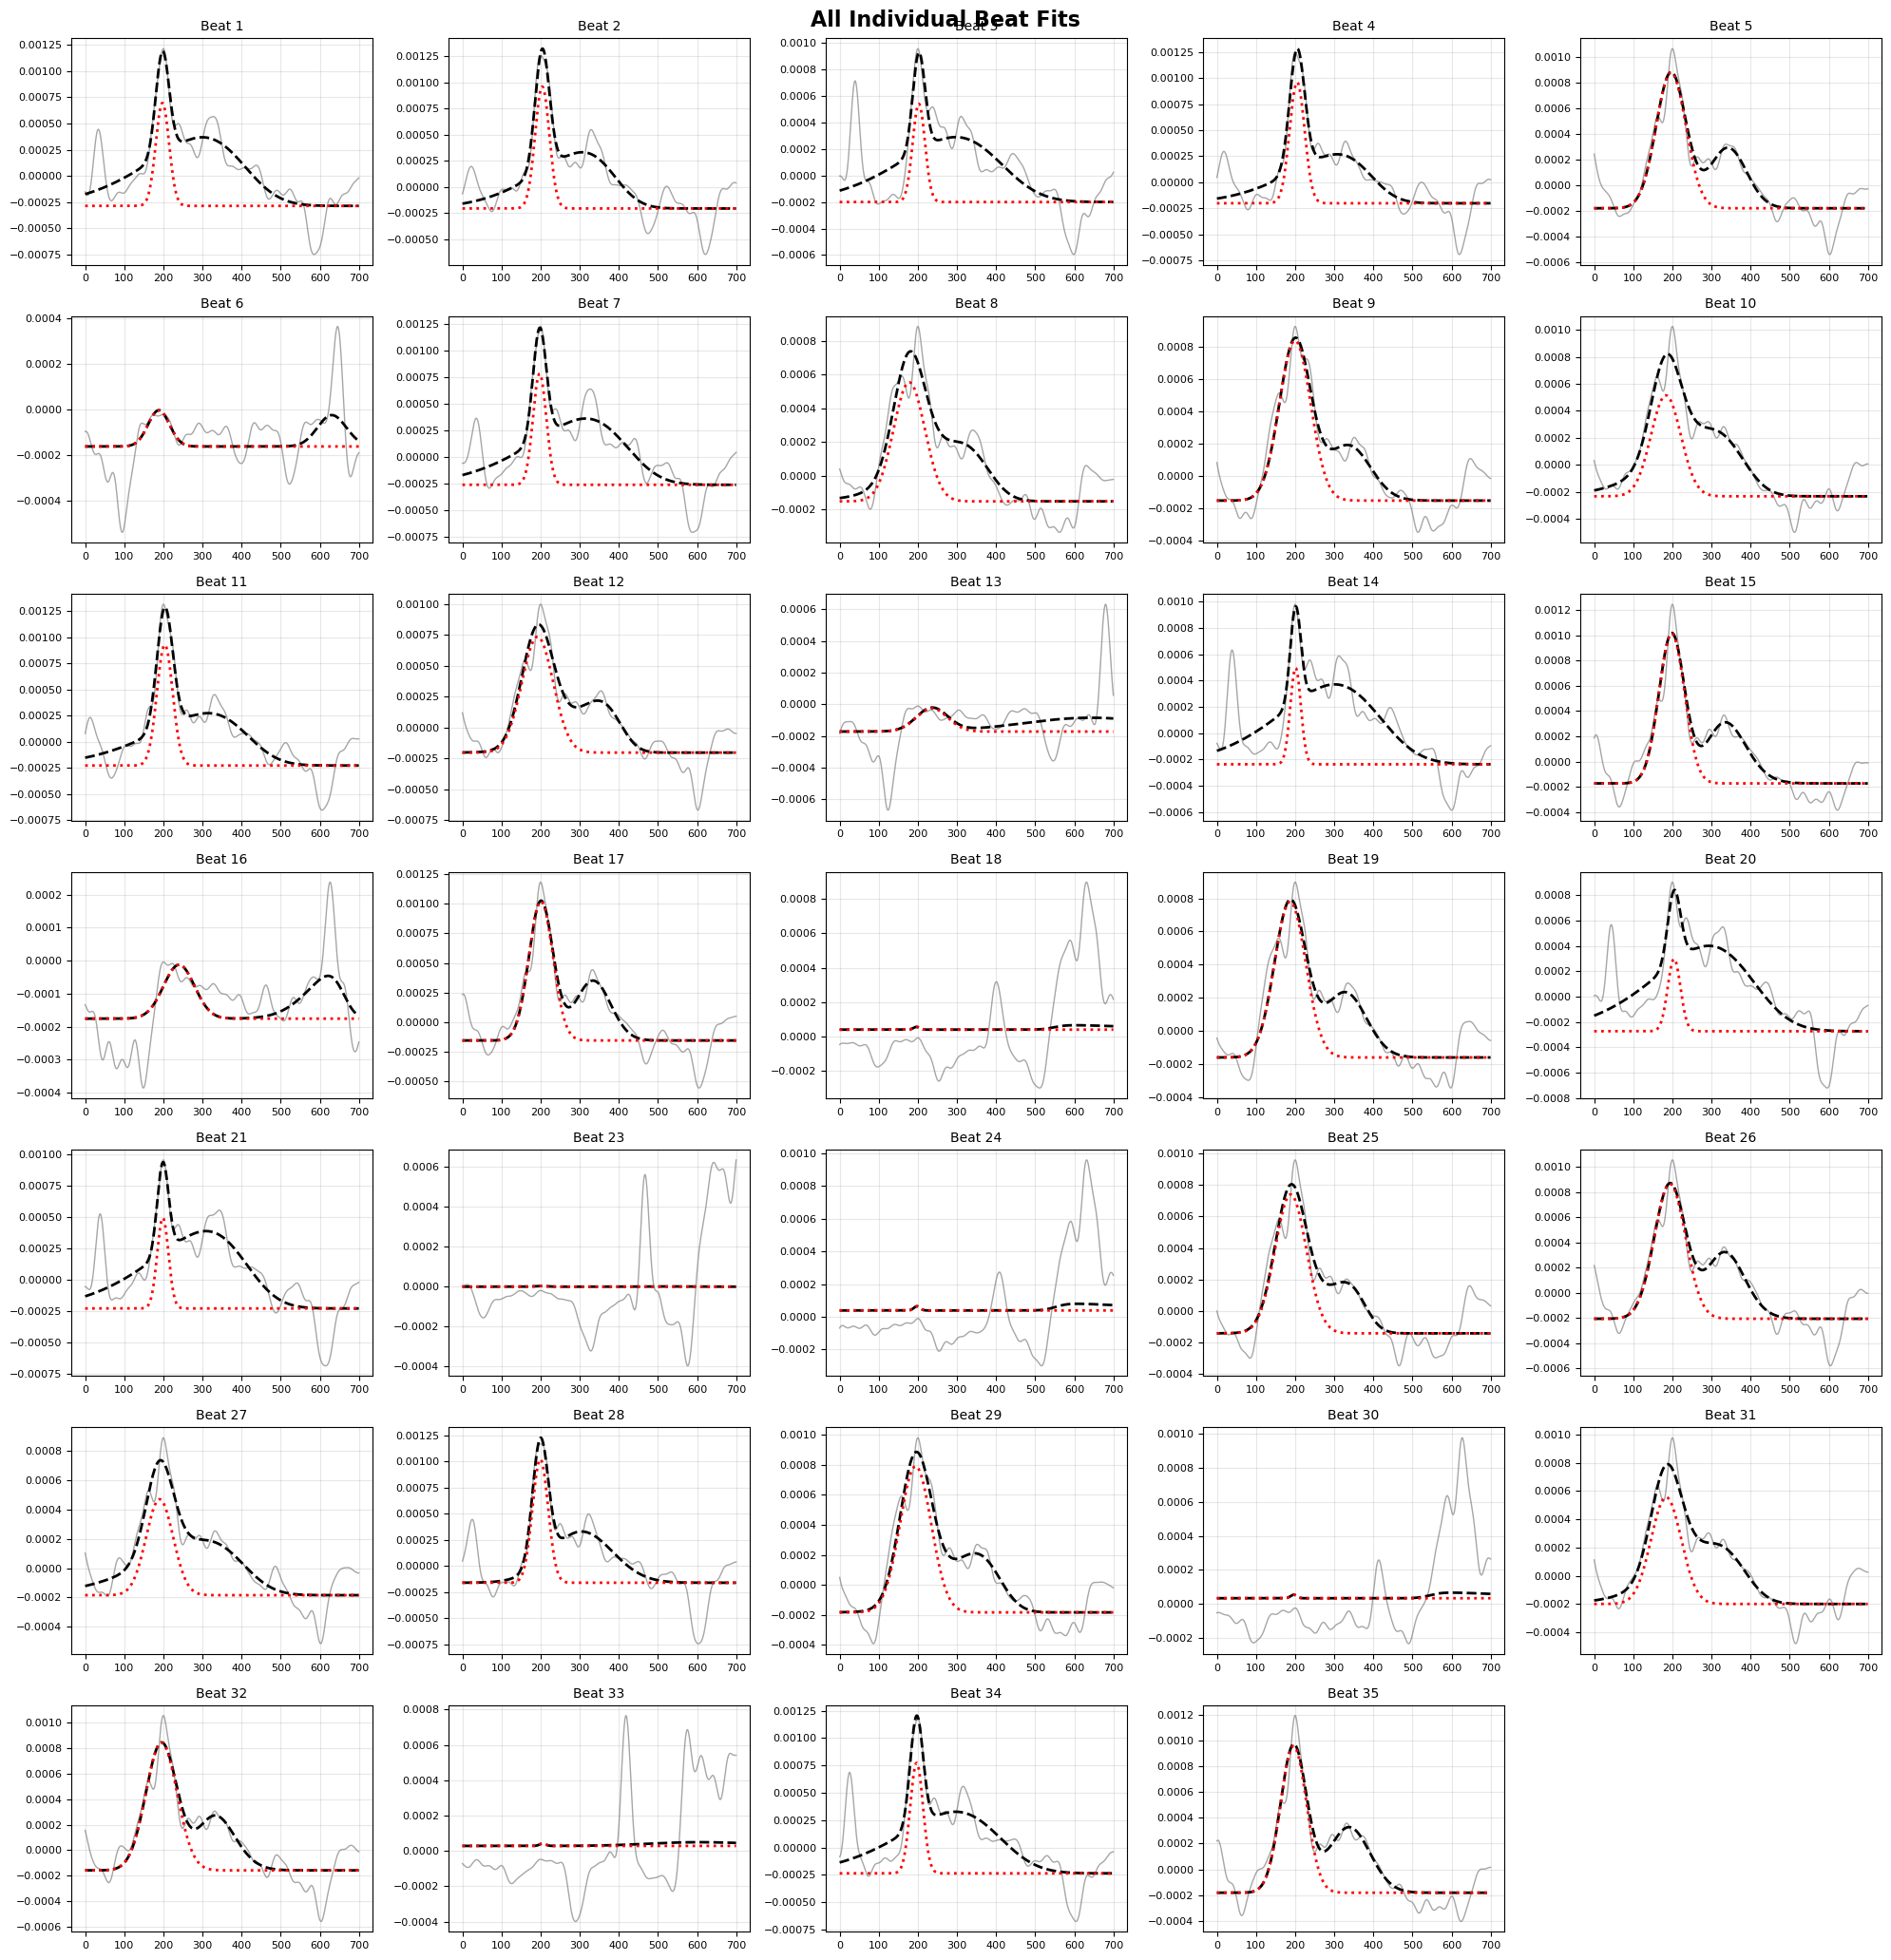


ECG ANALYSIS STATISTICS
Number of beats analyzed: 34

R wave amplitude:  7.42e-04 ± 4.09e-04
R wave width:      26.7 ± 12.0 ms

T wave amplitude:  3.87e-04 ± 2.01e-04
T/R amplitude ratio: 0.68 ± 0.38
T wave width:      136.9 ± 62.6 ms
T wave skewness:   -0.47 ± 3.13

R-T interval:      214.2 ± 84.7 ms

Mean RR interval:  1093.7 ± 662.3 ms
Heart rate:        54.9 ± 33.2 bpm


In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
from scipy.signal import find_peaks

# --- R + T wave model ---
def r_t_wave_model(x, r_pos, r_width, r_height, t_pos, t_width, t_skew, t_height, baseline):
    # R wave: narrow Gaussian
    r_wave = r_height * np.exp(-((x - r_pos) ** 2) / (2 * r_width ** 2))
    # T wave: skewed Gaussian
    t_wave = skewnorm.pdf(x, t_skew, loc=t_pos, scale=t_width)
    t_wave = t_height * t_wave / np.max(t_wave)
    return baseline + r_wave + t_wave

# --- Load your data ---
raw_ecg = ecg_data.copy().filter(1, 30, picks='ECG')
signal = raw_ecg.get_data()[0][210000:400000]
time = raw_ecg.times[210000:400000]
dt = np.mean(np.diff(time))
fs = 1 / dt

print(f"Sampling frequency: {fs:.1f} Hz")
print(f"Signal duration: {len(signal)/fs:.2f} seconds")
print(f"Signal range: [{signal.min():.2e}, {signal.max():.2e}]")

# --- BETTER R peak detection ---
# Strategy: R peaks are the TALLEST, SHARPEST peaks with regular spacing

# Step 1: Find all peaks
all_peaks, all_properties = find_peaks(signal, prominence=np.std(signal) * 0.5)

# Step 2: Calculate peak sharpness (how narrow they are)
sharpness = []
for peak in all_peaks:
    # Look at width of peak
    left = max(0, peak - int(0.05 * fs))
    right = min(len(signal), peak + int(0.05 * fs))
    width_at_half = np.sum(signal[left:right] > (signal[peak] * 0.5))
    sharpness.append(1.0 / (width_at_half + 1))  # Sharper = higher value

sharpness = np.array(sharpness)

# Step 3: Score peaks based on height and sharpness
height_scores = (signal[all_peaks] - np.min(signal)) / (np.max(signal) - np.min(signal))
sharpness_scores = (sharpness - np.min(sharpness)) / (np.max(sharpness) - np.min(sharpness) + 1e-10)
peak_scores = 0.7 * height_scores + 0.3 * sharpness_scores

# Step 4: Threshold to get R peaks (top scoring peaks)
score_threshold = np.percentile(peak_scores, 75)  # Take top 25%
r_peak_candidates = all_peaks[peak_scores > score_threshold]

# Step 5: Remove peaks that are too close (keep highest in each cluster)
min_rr_samples = int(0.4 * fs)  # Min 150 bpm
r_peaks = []
i = 0
while i < len(r_peak_candidates):
    current_peak = r_peak_candidates[i]
    # Find all peaks within min_rr_samples
    cluster_end = i
    while cluster_end < len(r_peak_candidates) - 1 and \
          r_peak_candidates[cluster_end + 1] - current_peak < min_rr_samples:
        cluster_end += 1
    
    # Keep the highest peak in cluster
    cluster_peaks = r_peak_candidates[i:cluster_end + 1]
    best_peak = cluster_peaks[np.argmax(signal[cluster_peaks])]
    r_peaks.append(best_peak)
    
    i = cluster_end + 1

r_peaks = np.array(r_peaks)

print(f"\nDetected {len(r_peaks)} R peaks")

if len(r_peaks) < 2:
    print("ERROR: Not enough R peaks detected. Trying alternative method...")
    # Fallback: just use highest peaks with minimum distance
    r_peaks, _ = find_peaks(signal, 
                            distance=int(0.4 * fs),
                            prominence=np.percentile(signal, 90) - np.median(signal))
    print(f"Detected {len(r_peaks)} R peaks with fallback method")

# --- Fit individual beats ---
fitted_beats = []
beat_params = []

for i, r_peak in enumerate(r_peaks):
    # Define window around R peak
    start_idx = max(0, r_peak - int(0.2 * fs))
    end_idx = min(len(signal), r_peak + int(0.5 * fs))  # Longer window for T wave
    
    if end_idx - start_idx < int(0.4 * fs):  # Skip if window too small
        continue
    
    # Extract beat
    beat_signal = signal[start_idx:end_idx]
    beat_x = np.arange(len(beat_signal))
    
    # Adjust R peak position relative to window
    r_pos_local = r_peak - start_idx
    
    # Find T peak (look after R peak, T is typically 0.2-0.4s after R)
    t_search_start = min(r_pos_local + int(0.15 * fs), len(beat_signal) - 1)
    t_search_end = min(r_pos_local + int(0.4 * fs), len(beat_signal))
    
    if t_search_end > t_search_start and t_search_end <= len(beat_signal):
        t_region = beat_signal[t_search_start:t_search_end]
        # T wave should be positive and smooth
        t_pos_local = t_search_start + np.argmax(t_region)
    else:
        t_pos_local = min(r_pos_local + int(0.28 * fs), len(beat_signal) - 1)
    
    # Initial guesses
    baseline_guess = np.median(beat_signal[:max(1, int(0.05 * fs))])
    r_height_guess = beat_signal[r_pos_local] - baseline_guess
    t_height_guess = max(0.05 * r_height_guess, beat_signal[t_pos_local] - baseline_guess)
    
    # Make sure T is not taller than R
    if t_height_guess > 0.8 * r_height_guess:
        t_height_guess = 0.4 * r_height_guess
    
    # Initial parameters
    p0 = [r_pos_local, max(1, fs*0.015), r_height_guess, 
          t_pos_local, max(1, fs*0.08), 2.5, t_height_guess, baseline_guess]
    
    # Bounds - R wave should be narrow and tall, T wave broader and shorter
    bounds = ([max(0, r_pos_local - fs*0.04), fs*0.008, r_height_guess*0.5, 
               max(r_pos_local + fs*0.1, t_pos_local - fs*0.08), fs*0.04, -3, 0, 
               baseline_guess - 2*np.std(beat_signal)],
              [min(len(beat_x)-1, r_pos_local + fs*0.04), fs*0.04, r_height_guess*1.5, 
               min(len(beat_x)-1, t_pos_local + fs*0.08), fs*0.2, 8, r_height_guess*0.8, 
               baseline_guess + 2*np.std(beat_signal)])
    
    try:
        popt, _ = curve_fit(r_t_wave_model, beat_x, beat_signal, 
                           p0=p0, bounds=bounds, maxfev=15000)
        
        fitted_beats.append({
            'signal': beat_signal,
            'x': beat_x,
            'params': popt,
            'start_idx': start_idx,
            'r_peak': r_peak,
            'beat_num': i
        })
        beat_params.append(popt)
        
    except Exception as e:
        print(f"Beat {i} fit failed: {e}")
        continue

print(f"\nSuccessfully fitted {len(fitted_beats)} beats")

# --- Plot results ---
if len(fitted_beats) > 0:
    # Plot 1: Full signal with detected R peaks
    fig = plt.figure(figsize=(18, 12))
    
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(time, signal, linewidth=1, color='black', alpha=0.7, label='ECG Signal')
    ax1.plot(time[r_peaks], signal[r_peaks], 'r^', markersize=10, label=f'Detected R peaks (n={len(r_peaks)})')
    ax1.set_xlabel("Time (s)", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Amplitude", fontsize=12, fontweight='bold')
    ax1.set_title("Full ECG Signal with Detected R Peaks", fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)
    
    # Plot 2: ALL R wave fits overlaid
    ax2 = plt.subplot(3, 1, 2)
    
    # Align all beats by R peak
    max_len_before = max([beat['params'][0] for beat in fitted_beats])
    max_len_after = max([len(beat['signal']) - beat['params'][0] for beat in fitted_beats])
    
    for i, beat_data in enumerate(fitted_beats):
        popt = beat_data['params']
        r_pos_local = popt[0]
        
        # Create aligned time axis (ms relative to R peak)
        beat_time_aligned = (beat_data['x'] - r_pos_local) / fs * 1000
        
        # Extract just R wave component
        beat_x = beat_data['x']
        r_component = popt[2] * np.exp(-((beat_x - popt[0]) ** 2) / (2 * popt[1] ** 2))
        
        # Plot R wave
        ax2.plot(beat_time_aligned, r_component, alpha=0.6, linewidth=1.5, 
                color='red', label='R fits' if i == 0 else '')
    
    ax2.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=2, label='R peak')
    ax2.set_xlabel("Time relative to R peak (ms)", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Amplitude", fontsize=12, fontweight='bold')
    ax2.set_title(f"All R Wave Fits Overlaid (n={len(fitted_beats)})", fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)
    ax2.set_xlim(-50, 100)
    
    # Plot 3: Individual beat with R and T components
    ax3 = plt.subplot(3, 1, 3)
    
    # Show first few beats with components
    n_show = min(3, len(fitted_beats))
    colors = plt.cm.tab10(np.linspace(0, 1, n_show))
    
    for i in range(n_show):
        beat_data = fitted_beats[i]
        popt = beat_data['params']
        beat_x = beat_data['x']
        beat_time_ms = beat_x / fs * 1000
        
        fitted_signal = r_t_wave_model(beat_x, *popt)
        r_component = popt[7] + popt[2] * np.exp(-((beat_x - popt[0]) ** 2) / (2 * popt[1] ** 2))
        t_wave_pdf = skewnorm.pdf(beat_x, popt[5], loc=popt[3], scale=popt[4])
        t_component = popt[7] + popt[6] * t_wave_pdf / np.max(t_wave_pdf)
        
        offset = i * 0.0  # No offset for clarity
        
        ax3.plot(beat_time_ms, beat_data['signal'] + offset, linewidth=1.5, alpha=0.5, 
                color=colors[i], label=f'Beat {beat_data["beat_num"]+1}')
        ax3.plot(beat_time_ms, fitted_signal + offset, '--', linewidth=2, 
                color=colors[i], alpha=0.9)
        ax3.plot(beat_time_ms, r_component + offset, ':', linewidth=2, 
                color='red', alpha=0.7)
        ax3.plot(beat_time_ms, t_component + offset, ':', linewidth=2, 
                color='blue', alpha=0.7)
    
    ax3.set_xlabel("Time (ms)", fontsize=12, fontweight='bold')
    ax3.set_ylabel("Amplitude", fontsize=12, fontweight='bold')
    ax3.set_title("Individual Beats: R (red) and T (blue) Wave Decomposition", fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # --- Additional plot: Grid of all beats ---
    n_beats = len(fitted_beats)
    n_cols = 5
    n_rows = int(np.ceil(n_beats / n_cols))
    
    fig2, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
    axes = axes.flatten() if n_beats > 1 else [axes]
    
    for i, beat_data in enumerate(fitted_beats):
        ax = axes[i]
        popt = beat_data['params']
        beat_x = beat_data['x']
        beat_time_ms = beat_x / fs * 1000
        
        fitted_signal = r_t_wave_model(beat_x, *popt)
        r_component = popt[7] + popt[2] * np.exp(-((beat_x - popt[0]) ** 2) / (2 * popt[1] ** 2))
        
        ax.plot(beat_time_ms, beat_data['signal'], linewidth=1, alpha=0.7, color='gray')
        ax.plot(beat_time_ms, fitted_signal, '--', linewidth=2, color='black')
        ax.plot(beat_time_ms, r_component, ':', linewidth=2, color='red')
        ax.set_title(f"Beat {beat_data['beat_num']+1}", fontsize=10)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=8)
    
    # Hide empty subplots
    for i in range(n_beats, len(axes)):
        axes[i].axis('off')
    
    fig2.suptitle("All Individual Beat Fits", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # --- Print statistics ---
    beat_params = np.array(beat_params)
    
    print("\n" + "=" * 70)
    print("ECG ANALYSIS STATISTICS")
    print("=" * 70)
    print(f"Number of beats analyzed: {len(fitted_beats)}")
    print(f"\nR wave amplitude:  {np.mean(beat_params[:, 2]):.2e} ± {np.std(beat_params[:, 2]):.2e}")
    print(f"R wave width:      {np.mean(beat_params[:, 1])/fs*1000:.1f} ± {np.std(beat_params[:, 1])/fs*1000:.1f} ms")
    print(f"\nT wave amplitude:  {np.mean(beat_params[:, 6]):.2e} ± {np.std(beat_params[:, 6]):.2e}")
    print(f"T/R amplitude ratio: {np.mean(beat_params[:, 6]/beat_params[:, 2]):.2f} ± {np.std(beat_params[:, 6]/beat_params[:, 2]):.2f}")
    print(f"T wave width:      {np.mean(beat_params[:, 4])/fs*1000:.1f} ± {np.std(beat_params[:, 4])/fs*1000:.1f} ms")
    print(f"T wave skewness:   {np.mean(beat_params[:, 5]):.2f} ± {np.std(beat_params[:, 5]):.2f}")
    
    # R-T intervals
    rt_intervals = (beat_params[:, 3] - beat_params[:, 0]) / fs * 1000
    print(f"\nR-T interval:      {np.mean(rt_intervals):.1f} ± {np.std(rt_intervals):.1f} ms")
    
    # Heart rate
    if len(r_peaks) > 1:
        rr_intervals = np.diff(r_peaks) / fs
        heart_rate = 60 / np.mean(rr_intervals)
        print(f"\nMean RR interval:  {np.mean(rr_intervals)*1000:.1f} ± {np.std(rr_intervals)*1000:.1f} ms")
        print(f"Heart rate:        {heart_rate:.1f} ± {60 * np.std(rr_intervals) / np.mean(rr_intervals)**2:.1f} bpm")
    print("=" * 70)
    
else:
    print("No beats could be fitted successfully!")

### current problem we dont always get t peak as reliable as we thought. wavelet is not working as well on this data as it did in test. this is odd. does it relate to cleaning or any other params?

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) metho

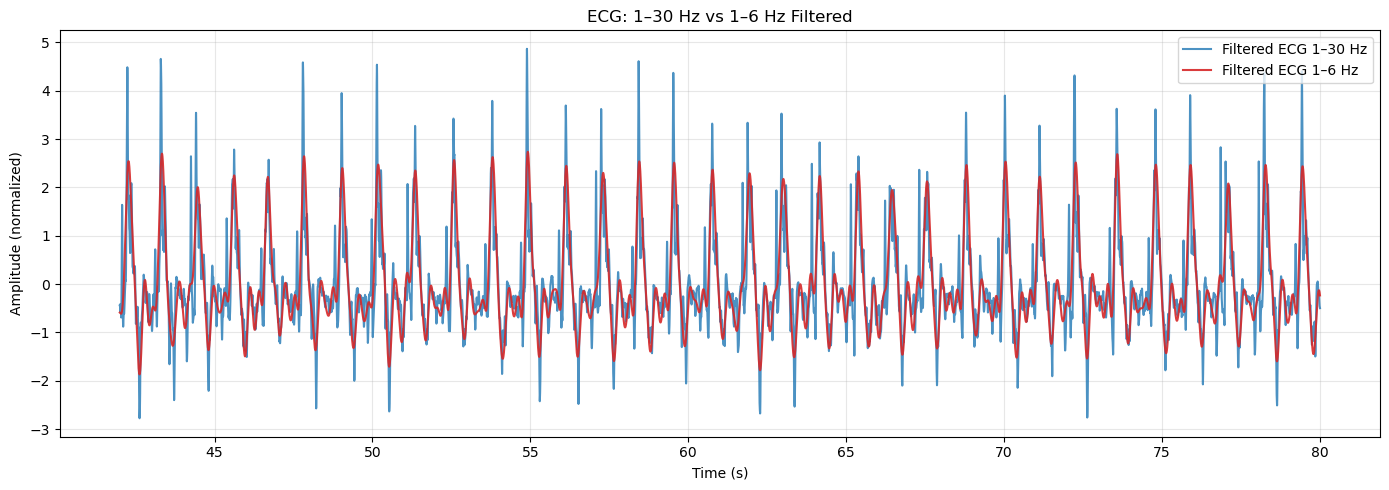

In [185]:
# --- Extract ECG signal window ---
time_window = slice(210000,400000)
time = ecg_data.times[time_window]

# --- Filter 1–30 Hz ---
raw_ecg_1_30 = ecg_data.copy().filter(1, 30, picks='ECG')
signal_1_30 = raw_ecg_1_30.get_data()[0][time_window]

# --- Filter 1–6 Hz ---
raw_ecg_1_6 = ecg_data.copy().filter(1, 3, picks='ECG')
signal_1_6 = raw_ecg_1_6.get_data()[0][time_window]

# --- Normalize for plotting ---
signal_1_30 = (signal_1_30 - np.mean(signal_1_30)) / np.std(signal_1_30)
signal_1_6 = (signal_1_6 - np.mean(signal_1_6)) / np.std(signal_1_6)

# --- Plot comparison ---
plt.figure(figsize=(14,5))
plt.plot(time, signal_1_30, label='Filtered ECG 1–30 Hz', alpha=0.8)
plt.plot(time, signal_1_6, label='Filtered ECG 1–6 Hz', alpha=0.9, color='tab:red')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (normalized)")
plt.title("ECG: 1–30 Hz vs 1–6 Hz Filtered")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) metho

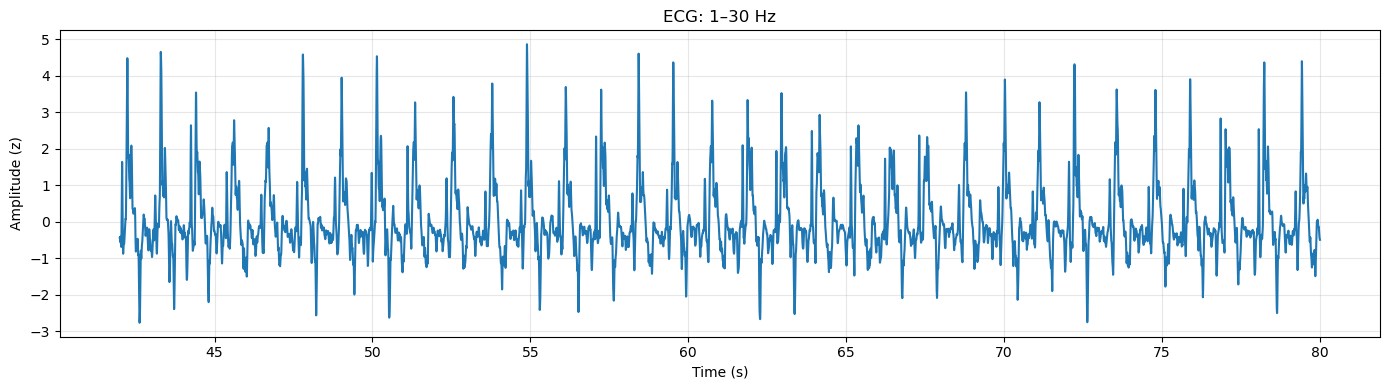

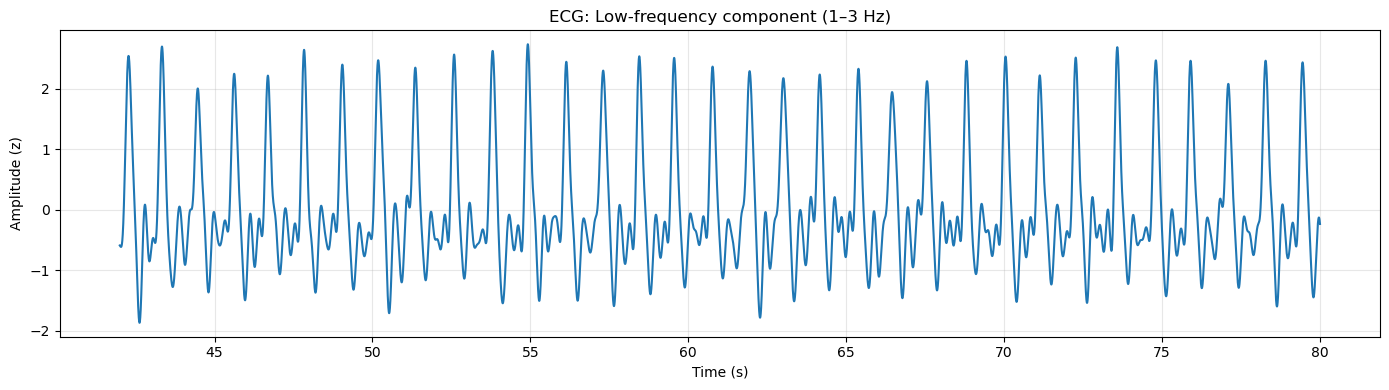

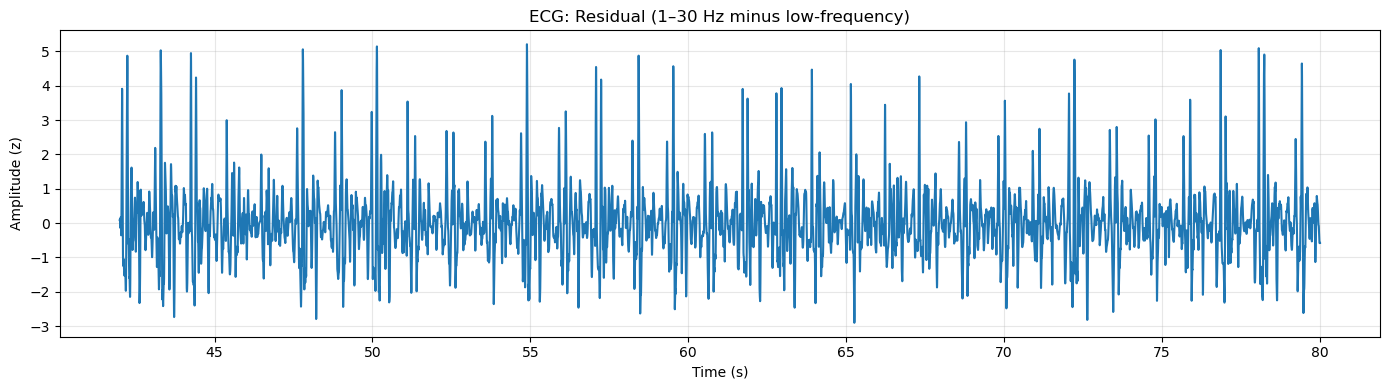

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# --- Extract ECG signal window ---
time_window = slice(210000, 400000)
time = ecg_data.times[time_window]

# --- Filter 1–30 Hz ---
raw_ecg_1_30 = ecg_data.copy().filter(1, 30, picks='ECG')
signal_1_30 = raw_ecg_1_30.get_data()[0][time_window]

# --- Filter low-frequency band (1–3 Hz) ---
raw_ecg_low = ecg_data.copy().filter(1, 3, picks='ECG')
signal_low = raw_ecg_low.get_data()[0][time_window]

# --- Subtract low-frequency component ---
signal_residual = signal_1_30 - signal_low

# --- Normalize for plotting ---
def zscore(x):
    return (x - np.mean(x)) / np.std(x)

signal_1_30_n = zscore(signal_1_30)
signal_low_n = zscore(signal_low)
signal_residual_n = zscore(signal_residual)

# =======================
# PLOTS
# =======================

plt.figure(figsize=(14,4))
plt.plot(time, signal_1_30_n)
plt.title("ECG: 1–30 Hz")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(time, signal_low_n)
plt.title("ECG: Low-frequency component (1–3 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(time, signal_residual_n)
plt.title("ECG: Residual (1–30 Hz minus low-frequency)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) metho

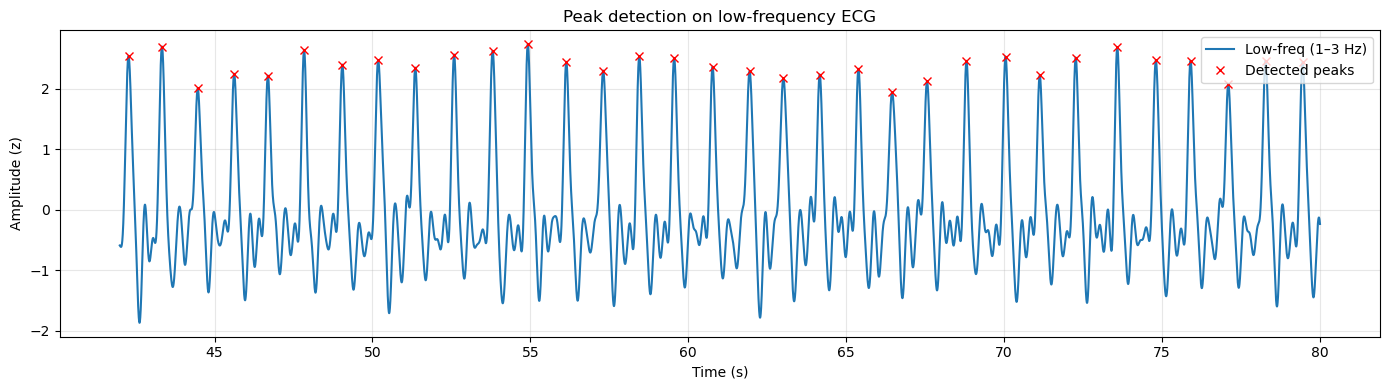

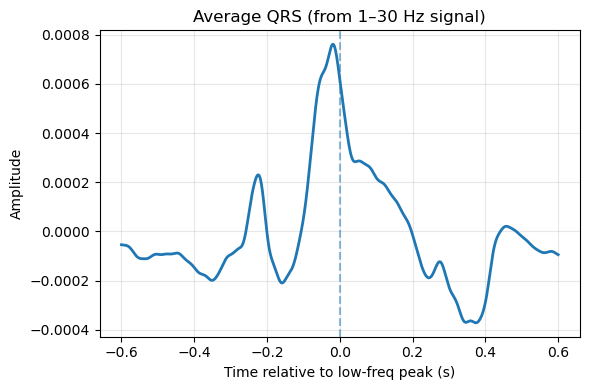

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# -----------------------------
# Extract ECG window
# -----------------------------
time_window = slice(210000, 400000)
time = ecg_data.times[time_window]
dt = np.mean(np.diff(time))
fs = 1 / dt

# -----------------------------
# Filters
# -----------------------------
raw_1_30 = ecg_data.copy().filter(1, 30, picks='ECG')
signal_1_30 = raw_1_30.get_data()[0][time_window]

raw_low = ecg_data.copy().filter(1, 3, picks='ECG')
signal_low = raw_low.get_data()[0][time_window]

# -----------------------------
# Normalize low-freq ONLY for peak detection
# -----------------------------
signal_low_z = (signal_low - np.mean(signal_low)) / np.std(signal_low)

# -----------------------------
# Peak detection on low-freq signal
# -----------------------------
min_rr_sec = 1   # ~120 bpm max
peaks, _ = find_peaks(
    signal_low_z,
    distance=int(min_rr_sec * fs),
    prominence=0.5
)

print(f"Detected {len(peaks)} beats")

# -----------------------------
# Epoch parameters (QRS window)
# -----------------------------
t_pre = 0.6    # 200 ms before peak
t_post = 0.6   # 400 ms after peak

n_pre = int(t_pre * fs)
n_post = int(t_post * fs)

epochs = []

for p in peaks:
    if p - n_pre < 0 or p + n_post >= len(signal_1_30):
        continue
    epoch = signal_1_30[p - n_pre : p + n_post]
    epochs.append(epoch)

epochs = np.array(epochs)

print(f"Kept {epochs.shape[0]} epochs")

# -----------------------------
# Average QRS
# -----------------------------
avg_qrs = np.mean(epochs, axis=0)
t_epoch = np.linspace(-t_pre, t_post, avg_qrs.size)

# -----------------------------
# PLOTS
# -----------------------------

# 1) Low-frequency signal + detected peaks
plt.figure(figsize=(14,4))
plt.plot(time, signal_low_z, label="Low-freq (1–3 Hz)")
plt.plot(time[peaks], signal_low_z[peaks], 'rx', label="Detected peaks")
plt.title("Peak detection on low-frequency ECG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (z)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Average QRS waveform
plt.figure(figsize=(6,4))
plt.plot(t_epoch, avg_qrs, lw=2)
plt.axvline(0, ls='--', alpha=0.5)
plt.title("Average QRS (from 1–30 Hz signal)")
plt.xlabel("Time relative to low-freq peak (s)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (3.300 s)

Detected 16 T-wave peaks
Detected 16 R-peaks

Heart Rate Statistics:
  Mean: 52.3 bpm
  Std:  2.3 bpm
  Min:  48.6 bpm
  Max:  57.3 bpm


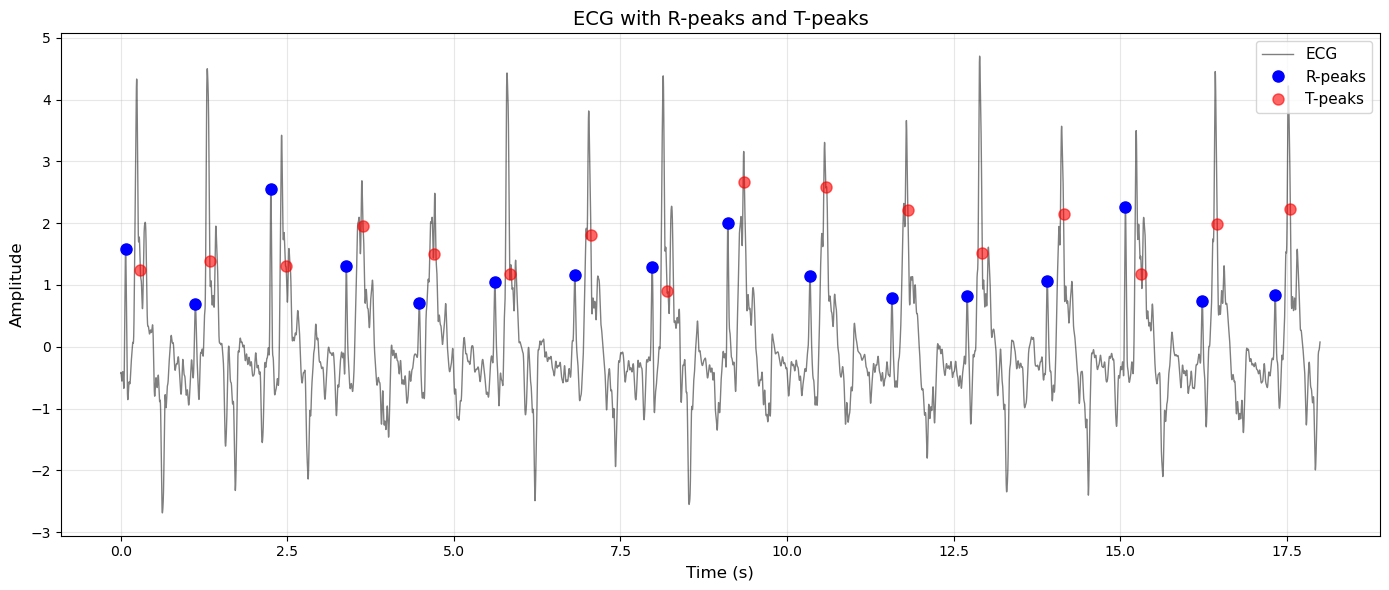

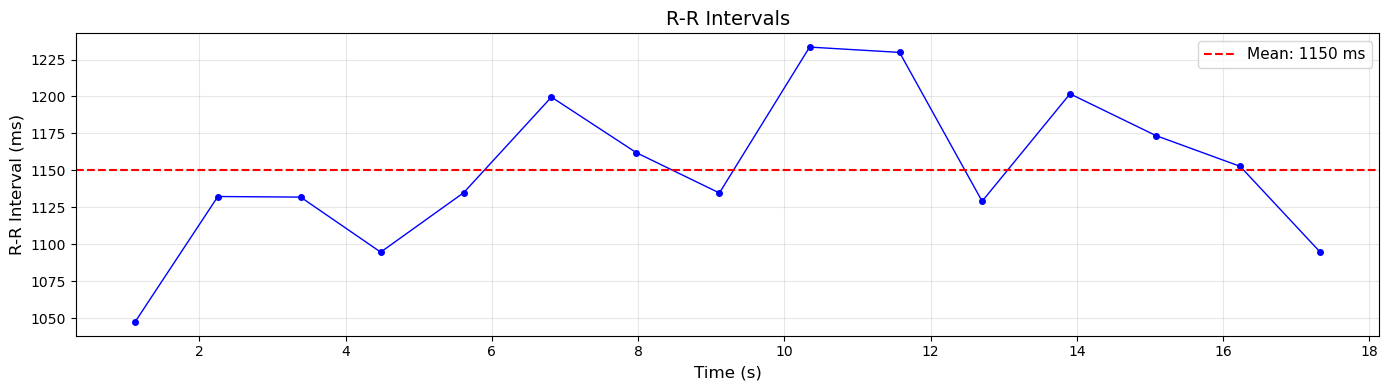


R-peak times (first 10): [ 0.0732  1.1208  2.2532  3.3852  4.48    5.615   6.8146  7.9766  9.1114
 10.3448]
R-peak sample indices (first 10): [  366  5604 11266 16926 22400 28075 34073 39883 45557 51724]


In [229]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

# -------------------------------
# T-wave detection using bandpass
# -------------------------------
def detect_A6_peaks(signal, fs, height_factor=1.5, min_distance_ms=400):
    """
    Detect T-wave peaks using 1–3 Hz bandpass filtered signal
    """
    # Apply bandpass filter instead of wavelet
    bp = bandpass_1_3hz(signal, fs)
    
    # Convert minimum distance from ms to samples
    min_distance_samples = int(min_distance_ms / 1000 * fs)
    
    peaks, _ = find_peaks(bp,
                          distance=min_distance_samples,
                          height=np.mean(bp) + height_factor * np.std(bp))
    return peaks

# -------------------------------
# R-peak detection with minimum distance constraint
# -------------------------------
def detect_R_peaks_simple(signal, T_peaks, fs, lookback_ms=300, exclude_ms=150, min_rr_ms=300):
    lookback_samples = int(lookback_ms / 1000 * fs)
    exclude_samples = int(exclude_ms / 1000 * fs)
    min_rr_samples = int(min_rr_ms / 1000 * fs)
    
    R_peaks = []
    
    for t in T_peaks:
        start = max(0, t - lookback_samples)
        end = max(0, t - exclude_samples)
        if end <= start:
            continue
        segment = signal[start:end]
        R_peak_position = start + np.argmax(segment)
        if len(R_peaks) == 0:
            R_peaks.append(R_peak_position)
        else:
            if R_peak_position - R_peaks[-1] >= min_rr_samples:
                R_peaks.append(R_peak_position)
            else:
                if signal[R_peak_position] > signal[R_peaks[-1]]:
                    R_peaks[-1] = R_peak_position
    return np.array(R_peaks)

# -------------------------------
# Visualization
# -------------------------------
def plot_peaks(signal, fs, T_peaks, R_peaks, title="ECG with R-peaks and T-peaks"):
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(14, 6))
    plt.plot(time, signal, 'k-', alpha=0.5, label='ECG', linewidth=1)
    plt.plot(R_peaks/fs, signal[R_peaks], 'bo', markersize=8, label='R-peaks', zorder=5)
    plt.plot(T_peaks/fs, signal[T_peaks], 'ro', markersize=8, label='T-peaks', alpha=0.6, zorder=4)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_rr_intervals(R_peaks, fs, title="R-R Intervals"):
    RR_intervals = np.diff(R_peaks) / fs * 1000
    RR_times = R_peaks[1:] / fs
    plt.figure(figsize=(14, 4))
    plt.plot(RR_times, RR_intervals, 'b-o', markersize=4, linewidth=1)
    plt.axhline(np.mean(RR_intervals), color='r', linestyle='--', label=f'Mean: {np.mean(RR_intervals):.0f} ms')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('R-R Interval (ms)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Main workflow
# -------------------------------
raw_ecg = ecg_data.copy().filter(1, 30, picks='ECG')
signal = raw_ecg.get_data()[0][210000:300000]
time = raw_ecg.times[210000:300000]
fs = 1 / np.mean(np.diff(time))

# Normalize
signal = (signal - np.mean(signal)) / np.std(signal)

# Step 1: Detect T-wave peaks (using 1-3 Hz bandpass)
T_peaks = detect_A6_peaks(signal, fs, min_distance_ms=400)
print(f"Detected {len(T_peaks)} T-wave peaks")

# Step 2: Detect R-peaks
R_peaks = detect_R_peaks_simple(signal, T_peaks, fs, lookback_ms=300, exclude_ms=150, min_rr_ms=400)
print(f"Detected {len(R_peaks)} R-peaks")

# Step 3: Heart rate statistics
RR_intervals = np.diff(R_peaks) / fs
heart_rate = 60 / RR_intervals
print(f"\nHeart Rate Statistics:")
print(f"  Mean: {np.mean(heart_rate):.1f} bpm")
print(f"  Std:  {np.std(heart_rate):.1f} bpm")
print(f"  Min:  {np.min(heart_rate):.1f} bpm")
print(f"  Max:  {np.max(heart_rate):.1f} bpm")

# Plots
plot_peaks(signal, fs, T_peaks, R_peaks)
plot_rr_intervals(R_peaks, fs)

# Optional: Export R-peak times
R_peak_times = R_peaks / fs
print(f"\nR-peak times (first 10): {R_peak_times[:10]}")
print(f"R-peak sample indices (first 10): {R_peaks[:10]}")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Detected 16 T-peaks
Detected 16 R-peaks

Heart Rate Statistics:
  Mean: 52.3 bpm
  Std:  2.3 bpm
  Min:  48.7 bpm
  Max:  57.3 bpm


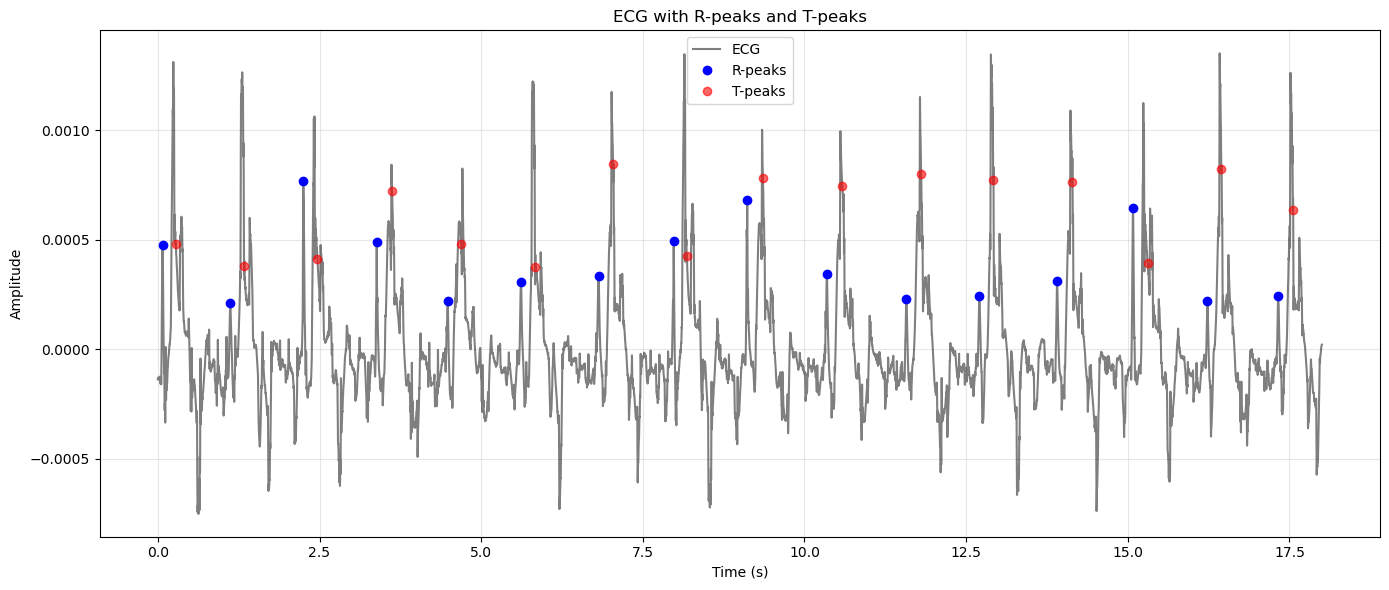

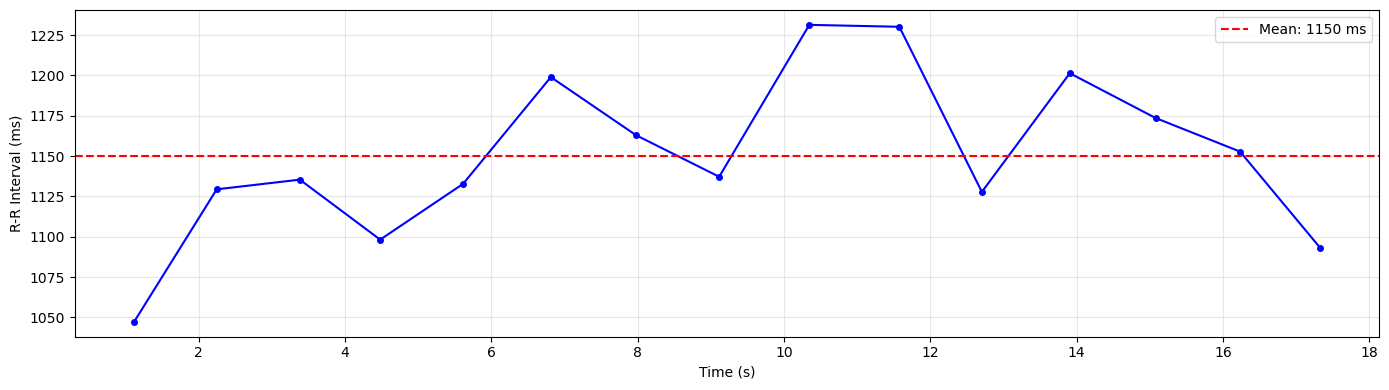


R-peak times (first 10): [ 0.0724  1.1196  2.249   3.3844  4.4826  5.6154  6.8144  7.9774  9.1146
 10.346 ]


In [247]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.signal import find_peaks

# -------------------------------
# T-wave detection using MNE filtering
# -------------------------------
def detect_T_peaks(raw, picks='ECG', l_freq=1, h_freq=3, height_factor=1.5, min_distance_ms=300):
    """
    Detect T-wave peaks using bandpass filtered ECG signal (1–3 Hz)
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw ECG data
    picks : str or list
        Channels to use for detection
    l_freq : float
        Low cutoff frequency (Hz)
    h_freq : float
        High cutoff frequency (Hz)
    height_factor : float
        Threshold factor for peak detection
    min_distance_ms : float
        Minimum distance between T-peaks in ms
    
    Returns
    -------
    T_peaks : ndarray
        Sample indices of detected T-peaks
    bp_signal : ndarray
        Bandpass-filtered signal used for detection
    """
    # Get data
    ecg_data = raw.copy().pick_channels([picks]).get_data()[0]
    
    # Bandpass filter (1–3 Hz)
    bp_signal = raw.copy().pick_channels([picks]).filter(
        l_freq, h_freq, picks=picks, verbose=False
    ).get_data()[0]
    
    # Minimum distance in samples
    min_dist_samples = int(min_distance_ms / 1000 * raw.info['sfreq'])
    
    # Peak detection
    peaks, _ = find_peaks(bp_signal,
                          distance=min_dist_samples,
                          height=np.mean(bp_signal) + height_factor * np.std(bp_signal))
    return peaks, bp_signal

# -------------------------------
# R-peak detection relative to T-peaks
# -------------------------------
def detect_R_peaks(ecg_signal, T_peaks, fs, lookback_ms=300, exclude_ms=150, min_rr_ms=100):
    lookback_samples = int(lookback_ms / 1000 * fs)
    exclude_samples = int(exclude_ms / 1000 * fs)
    min_rr_samples = int(min_rr_ms / 1000 * fs)
    
    R_peaks = []
    for t in T_peaks:
        start = max(0, t - lookback_samples)
        end = max(0, t - exclude_samples)
        if end <= start:
            continue
        segment = ecg_signal[start:end]
        R_pos = start + np.argmax(segment)
        if len(R_peaks) == 0 or (R_pos - R_peaks[-1]) >= min_rr_samples:
            R_peaks.append(R_pos)
        else:
            if ecg_signal[R_pos] > ecg_signal[R_peaks[-1]]:
                R_peaks[-1] = R_pos
    return np.array(R_peaks)

# -------------------------------
# Plotting functions
# -------------------------------
def plot_peaks(ecg_signal, fs, T_peaks, R_peaks, title="ECG with R-peaks and T-peaks"):
    time = np.arange(len(ecg_signal)) / fs
    plt.figure(figsize=(14,6))
    plt.plot(time, ecg_signal, 'k-', alpha=0.5, label='ECG')
    plt.plot(R_peaks/fs, ecg_signal[R_peaks], 'bo', label='R-peaks', zorder=5)
    plt.plot(T_peaks/fs, ecg_signal[T_peaks], 'ro', label='T-peaks', alpha=0.6)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_rr_intervals(R_peaks, fs):
    RR_intervals = np.diff(R_peaks) / fs * 1000  # ms
    RR_times = R_peaks[1:] / fs
    plt.figure(figsize=(14,4))
    plt.plot(RR_times, RR_intervals, 'b-o', markersize=4)
    plt.axhline(np.mean(RR_intervals), color='r', linestyle='--', label=f'Mean: {np.mean(RR_intervals):.0f} ms')
    plt.xlabel('Time (s)')
    plt.ylabel('R-R Interval (ms)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Main workflow
# -------------------------------
# Copy & filter raw ECG
raw_ecg = ecg_data.copy().filter(1, 100, picks='ECG', verbose=False)
fs = raw_ecg.info['sfreq']

# Slice data for analysis (optional)
start_sample = 210000
end_sample   = 300000
signal = raw_ecg.get_data(picks=['ECG'])[0, start_sample:end_sample]

# Step 1: Detect T-peaks
T_peaks, bp_signal = detect_T_peaks(raw_ecg, picks='ECG', l_freq=1, h_freq=3, min_distance_ms=400)
T_peaks = T_peaks[(T_peaks >= start_sample) & (T_peaks < end_sample)] - start_sample
print(f"Detected {len(T_peaks)} T-peaks")

# Step 2: Detect R-peaks relative to T-peaks
R_peaks = detect_R_peaks(signal, T_peaks, fs, lookback_ms=300, exclude_ms=150, min_rr_ms=400)
print(f"Detected {len(R_peaks)} R-peaks")

# Step 3: Heart rate statistics
RR_intervals = np.diff(R_peaks) / fs
heart_rate = 60 / RR_intervals
print(f"\nHeart Rate Statistics:")
print(f"  Mean: {np.mean(heart_rate):.1f} bpm")
print(f"  Std:  {np.std(heart_rate):.1f} bpm")
print(f"  Min:  {np.min(heart_rate):.1f} bpm")
print(f"  Max:  {np.max(heart_rate):.1f} bpm")

# Step 4: Plots
plot_peaks(signal, fs, T_peaks, R_peaks)
plot_rr_intervals(R_peaks, fs)

# Optional: Export R-peak times
R_peak_times = R_peaks / fs
print(f"\nR-peak times (first 10): {R_peak_times[:10]}")


Detected 645 T-peaks
Detected 645 R-peaks
Mean HR: 52.6 ± 3.2 bpm


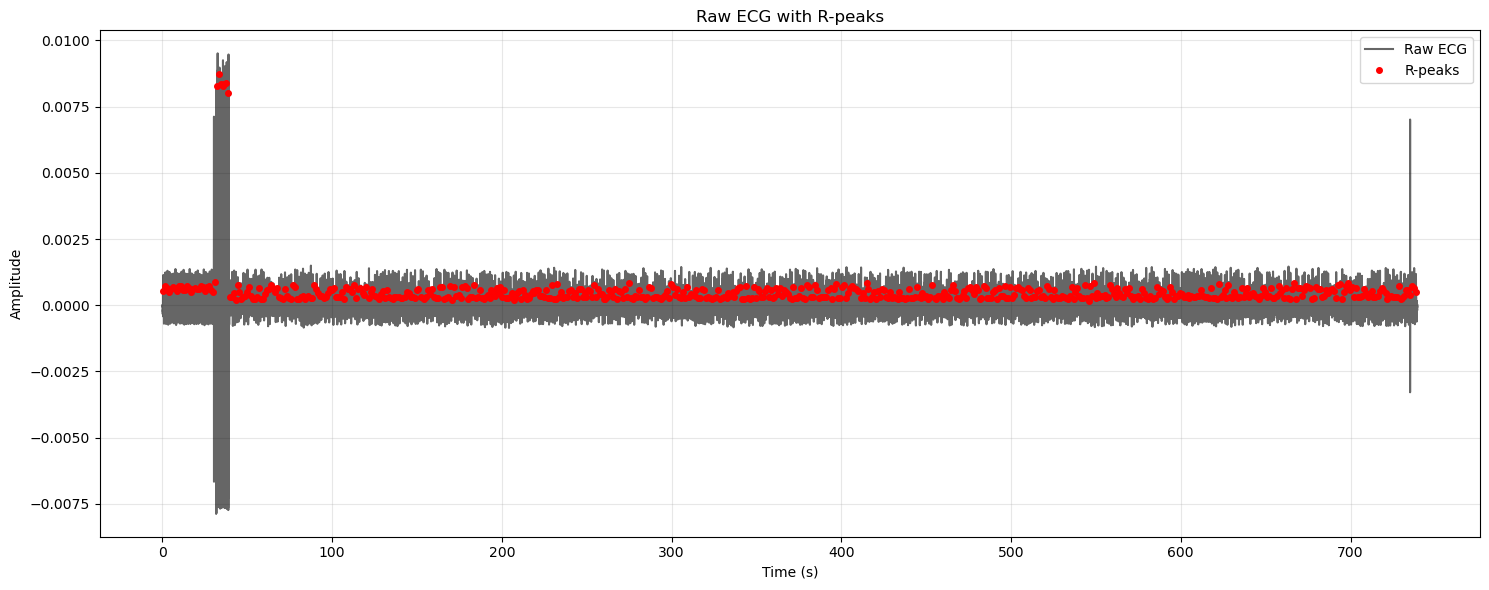

R-peaks added to raw.annotations ✔


<mne_qt_browser._pg_figure.MNEQtBrowser(0x15ba3555cb0) at 0x0000015B9E293500>

Channels marked as bad:
none


In [260]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.signal import find_peaks

# -------------------------------
# T-wave detection (band-limited envelope)
# -------------------------------
def detect_T_peaks(raw, picks='ECG', l_freq=1, h_freq=3,
                   height_factor=1.5, min_distance_ms=300):

    fs = raw.info['sfreq']

    bp_signal = (
        raw.copy()
        .pick(picks)
        .filter(l_freq, h_freq, verbose=False,picks='ECG')
        .get_data()[0]
    )

    min_dist_samples = int(min_distance_ms / 1000 * fs)

    peaks, _ = find_peaks(
        bp_signal,
        distance=min_dist_samples,
        height=np.mean(bp_signal) + height_factor * np.std(bp_signal)
    )

    return peaks, bp_signal


# -------------------------------
# R-peak detection (relative to T)
# -------------------------------
def detect_R_peaks(ecg_signal, T_peaks, fs,
                   lookback_ms=300, exclude_ms=150, min_rr_ms=400):

    lookback = int(lookback_ms / 1000 * fs)
    exclude  = int(exclude_ms / 1000 * fs)
    min_rr   = int(min_rr_ms / 1000 * fs)

    R_peaks = []

    for t in T_peaks:
        start = max(0, t - lookback)
        end   = max(0, t - exclude)
        if end <= start:
            continue

        seg = ecg_signal[start:end]
        r = start + np.argmax(seg)

        if not R_peaks or (r - R_peaks[-1]) >= min_rr:
            R_peaks.append(r)
        elif ecg_signal[r] > ecg_signal[R_peaks[-1]]:
            R_peaks[-1] = r

    return np.array(R_peaks, dtype=int)


# -------------------------------
# Plot raw ECG with R-peaks
# -------------------------------
def plot_raw_with_R_peaks(raw, R_peaks, picks='ECG'):
    ecg = raw.copy().pick(picks).get_data()[0]
    fs = raw.info['sfreq']
    time = np.arange(len(ecg)) / fs

    plt.figure(figsize=(15, 6))
    plt.plot(time, ecg, 'k', alpha=0.6, label='Raw ECG')
    plt.plot(R_peaks / fs, ecg[R_peaks],
             'ro', ms=4, label='R-peaks')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Raw ECG with R-peaks")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ===============================
# MAIN WORKFLOW (FULL TIMESERIES)
# ===============================

raw_ecg = ecg_data.copy().filter(1, 100, picks='ECG', verbose=False)
fs = raw_ecg.info['sfreq']

ecg_signal = raw_ecg.get_data(picks='ECG')[0]

# ---- T-peaks ----
T_peaks, bp_signal = detect_T_peaks(
    raw_ecg,
    picks='ECG',
    l_freq=1,
    h_freq=3,
    min_distance_ms=400
)

print(f"Detected {len(T_peaks)} T-peaks")

# ---- R-peaks ----
R_peaks = detect_R_peaks(
    ecg_signal,
    T_peaks,
    fs,
    lookback_ms=300,
    exclude_ms=150,
    min_rr_ms=400
)

print(f"Detected {len(R_peaks)} R-peaks")

# ---- Heart rate ----
RR = np.diff(R_peaks) / fs
HR = 60 / RR
print(f"Mean HR: {np.mean(HR):.1f} ± {np.std(HR):.1f} bpm")

# ---- Plot ----
plot_raw_with_R_peaks(raw_ecg, R_peaks)

# -------------------------------
# ADD R-PEAKS AS MNE ANNOTATIONS
# -------------------------------
onsets = R_peaks / fs

orig_time = raw_ecg.annotations.orig_time if raw_ecg.annotations is not None else None

rpeak_annots = mne.Annotations(
    onset=onsets,
    duration=np.zeros(len(onsets)),
    description=['ECG/R-peak'] * len(onsets),
    orig_time=orig_time
)

# Append safely
if raw_ecg.annotations is not None and len(raw_ecg.annotations) > 0:
    raw_ecg.set_annotations(raw_ecg.annotations + rpeak_annots)
else:
    raw_ecg.set_annotations(rpeak_annots)

print("R-peaks added to raw.annotations ✔")

# ---- Interactive scroll ----
raw_ecg.plot(
    picks='ECG',
    duration=10,
    start=max(0, onsets[0] - 1),
    scalings='auto'
)


In [263]:
raw.plot()

<mne_qt_browser._pg_figure.MNEQtBrowser(0x15ba8e476e0) at 0x0000015BADB607C0>

Channels marked as bad:
none


    ### TEST RUN 29/01/2026

In [5]:
raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)

Extracting parameters from C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3696599  =      0.000 ...   739.320 secs...


C:\Users\brand\AppData\Local\Temp\ipykernel_8172\401351902.py:1: RuntimeWarning: No coordinate information found for channels ['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)
C:\Users\brand\AppData\Local\Temp\ipykernel_8172\401351902.py:1: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['ECG', 'CWL1', 'CWL2', 'CWL3', 'CWL4']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw(r"C:\Users\brand\Documents\eeg_fmri_denoising_software\test_data\sub-01_task-da_run-03_eeg.vhdr", preload = True)


In [6]:
clean_raw = remove_gradients(raw,  window_length=61,baseline_correction=True)

Used Annotations descriptions: [np.str_('Gradient/G  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S255'), np.str_('SyncStatus/Sync On')]
Scanner Repetition Time = 1.500 s
(0,)
Not setting metadata
464 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 464 events and 7500 original time points ...
0 bad epochs dropped


In [7]:
clean_raw.set_channel_types({'ECG' : 'ecg'})

C:\Users\brand\AppData\Local\Temp\ipykernel_8172\2849097989.py:1: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  clean_raw.set_channel_types({'ECG' : 'ecg'})


<RawBrainVision | sub-01_task-da_run-03_eeg.eeg, 68 x 3696600 (739.3 s), ~1.87 GiB, data loaded>

In [13]:
import numpy as np
import mne
from scipy.signal import find_peaks

# ---------------------------------------------------------
# Detect T-waves, infer R-peaks, annotate Raw, return Raw
# ---------------------------------------------------------
def annotate_R_peaks_for_BCG(
    raw,
    picks='ecg',
    t_l_freq=1,
    t_h_freq=3,
    qrs_l_freq=1,
    qrs_h_freq=100,
    height_factor=1.5,
    min_distance_ms=300,
    lookback_ms=300,
    exclude_ms=150,
    min_rr_ms=400
):
    """
    Returns a Raw object with R-peak annotations added.
    Existing annotations are preserved.
    """

    raw = raw.copy()
    fs = raw.info['sfreq']

    # -------------------------
    # Low-frequency signal (T-wave envelope)
    # -------------------------
    t_signal = (
        raw.copy()
        .pick(picks)
        .filter(t_l_freq, t_h_freq,picks='ecg', verbose=False)
        .get_data()[0]
    )

    # -------------------------
    # Broadband ECG (QRS)
    # -------------------------
    qrs_signal = (
        raw.copy()
        .pick(picks)
        .filter(qrs_l_freq, qrs_h_freq, picks='ecg', verbose=False)
        .get_data()[0]
    )

    # -------------------------
    # Detect T-peaks
    # -------------------------
    min_dist_samples = int(min_distance_ms / 1000 * fs)

    T_peaks, _ = find_peaks(
        t_signal,
        distance=min_dist_samples,
        height=np.mean(t_signal) + height_factor * np.std(t_signal)
    )

    if len(T_peaks) == 0:
        raise RuntimeError("No T-peaks detected")

    # -------------------------
    # Detect R-peaks relative to T-peaks
    # -------------------------
    R_peaks = detect_R_peaks(
        qrs_signal,
        T_peaks,
        fs,
        lookback_ms=lookback_ms,
        exclude_ms=exclude_ms,
        min_rr_ms=min_rr_ms
    )

    if len(R_peaks) == 0:
        raise RuntimeError("No R-peaks detected")

    # -------------------------
    # Create annotations
    # -------------------------
    onsets = R_peaks / fs
    durations = np.zeros(len(onsets))
    descriptions = ['ECG/R-peak'] * len(onsets)

    orig_time = raw.annotations.orig_time if raw.annotations is not None else None

    rpeak_annots = mne.Annotations(
        onset=onsets,
        duration=durations,
        description=descriptions,
        orig_time=orig_time
    )

    # -------------------------
    # Append annotations safely
    # -------------------------
    if raw.annotations is not None and len(raw.annotations) > 0:
        raw.set_annotations(raw.annotations + rpeak_annots)
    else:
        raw.set_annotations(rpeak_annots)

    print(f"✔ Added {len(R_peaks)} R-peak annotations to Raw")

    return raw


In [15]:
# -------------------------------
# R-peak detection relative to T-peaks
# -------------------------------
def detect_R_peaks(ecg_signal, T_peaks, fs, lookback_ms=300, exclude_ms=150, min_rr_ms=100):
    lookback_samples = int(lookback_ms / 1000 * fs)
    exclude_samples = int(exclude_ms / 1000 * fs)
    min_rr_samples = int(min_rr_ms / 1000 * fs)
    
    R_peaks = []
    for t in T_peaks:
        start = max(0, t - lookback_samples)
        end = max(0, t - exclude_samples)
        if end <= start:
            continue
        segment = ecg_signal[start:end]
        R_pos = start + np.argmax(segment)
        if len(R_peaks) == 0 or (R_pos - R_peaks[-1]) >= min_rr_samples:
            R_peaks.append(R_pos)
        else:
            if ecg_signal[R_pos] > ecg_signal[R_peaks[-1]]:
                R_peaks[-1] = R_pos
    return np.array(R_peaks)


In [16]:
raw_bcg_ready = annotate_R_peaks_for_BCG(raw)

✔ Added 645 R-peak annotations to Raw


In [18]:
raw_bcg_ready.plot()

<mne_qt_browser._pg_figure.MNEQtBrowser(0x20904e86ed0) at 0x0000020904A1B440>

In [ ]:
raw.copy().pick('ECG').filter(7,40, picks='ecg').plot()

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 8251 samples (1.650 s)



<mne_qt_browser._pg_figure.MNEQtBrowser(0x2091bc65390) at 0x0000020906CF3780>

Channels marked as bad:
none
Channels marked as bad:
none
